# Import important libraries

In [1]:
import time
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from math import *
import math
from datetime import datetime, timedelta
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.ticker import MaxNLocator
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import seaborn as sns
import tensorflow as tf
from keras.utils import plot_model
import keras 
import plotly.graph_objects as go
import math
import plotly.subplots as sp
import plotly.graph_objects as go
from keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import Callback
import plotly.graph_objects as go
import kaleido



mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Import inventory management files : GKT

Imporatation des données de la gestion de stock de toutes les années en un data frame

In [2]:
data_GKT_2021_2024 = pd.read_csv('sortie_stock_GKT_2021_2024.csv', encoding='ISO-8859-1', delimiter=';') # mettre a jour sortie_stock_GKT_2021_2024 pour tenir en compte des nouvelles données

data_GKT_2018_2020 = pd.read_csv('sortie_stock_GKT_2018_2020.csv', encoding='ISO-8859-1', delimiter=';')

data_GKT_2015_2017 = pd.read_csv('sortie_stock_GKT_2015_2017.csv', encoding='ISO-8859-1', delimiter=';',low_memory=False) # low_memory=False option added for SAAGIE

data_GKT_2010_2014 = pd.read_csv('sortie_stock_GKT_2010_2014.csv', encoding='ISO-8859-1', delimiter=';')


result_append_1 = pd.concat([data_GKT_2021_2024, data_GKT_2018_2020])
result_append_2 = pd.concat([data_GKT_2015_2017, data_GKT_2010_2014])

data_GKT = pd.concat([result_append_1, result_append_2])

data_GKT = data_GKT[(data_GKT["Type de transaction"].isin(["Retour d'article", "Sortie d'article"]))] # filtre : prendre selement Retour d'article"et"Sortie d'article

data_GKT['Date de sortie'] = pd.to_datetime(data_GKT['Date de sortie'], format='%d/%m/%Y')


data_GKT["Quantité sortie"] = pd.to_numeric(data_GKT["Quantité sortie"], errors='coerce')

# Drop the rows with NaN values
data_GKT.dropna(subset=["Quantité sortie"], inplace=True) # pas beaucoup de lignes qui ont une quantité NAN

data_GKT["Quantité sortie"] = data_GKT["Quantité sortie"].astype(int)


# Drop the rows with NaN values
data_GKT.dropna(subset=['Quantité sortie'], inplace=True) ## pas beaucoup de lignes qui ont une quantité sortie qui n'est pas un entier


# data_GKT.to_excel('merged_data_stock.xlsx', index=False)
# print("Résultat exporté en Excel.")

# print('Data type of each column of Dataframe :')
# data_GKT.info(verbose=True)


In [3]:
# print('Data type of each column of Dataframe :')
# data_GKT_2015_2017.info(verbose=True)

Regrouper les codes articles équivalents et chancger le fichier d'origine en prenant qu'une seule réference de pièce (CAT)

In [4]:
# ref_pieces = pd.read_csv('ref_pieces.csv', encoding='ISO-8859-1', delimiter=';')

# print('Data type of each column of Dataframe :')
# ref_pieces.info(verbose=True)

# # Create an empty dictionary
# data_dict = {}

# # Iterate over the rows of the DataFrame
# for index, row in ref_pieces.iterrows():
#     name = row['PARTS']
#     ref1 = row['Ref Berco']
#     ref2 = row['CAT']
    
#     # Add the name as the key and the values of ref1 and ref2 as the value to the dictionary
#     data_dict[ref1] = (name)
#     data_dict[ref2] = (name)

# # print(data_dict)
# data_GKT['Code article'] = data_GKT['Code article'].replace(data_dict)


# data_GKT.to_excel('data_compartiment.xlsx', index=False)
# print("Résultat exporté en Excel.")

# print('Data type of each column of Dataframe :')
# data_GKT.info(verbose=True)

In [5]:
ref_pieces = pd.read_csv('ref_pieces_new.csv', encoding='ISO-8859-1', delimiter=';')

print('Data type of each column of Dataframe :')
ref_pieces.info(verbose=True)

# Create an empty dictionary
data_dict = {}

# Iterate over the rows of the DataFrame
for index, row in ref_pieces.iterrows():
    name = row['PARTS']
    ref1 = row['Ref équivalente']
    
    
    # Add the name as the key and the values of ref1 and ref2 as the value to the dictionary
    data_dict[ref1] = (name)
    

# print(data_dict)
data_GKT['Code article'] = data_GKT['Code article'].replace(data_dict)


# data_GKT.to_excel('data_compartiment.xlsx', index=False)
# print("Résultat exporté en Excel.")

# print('Data type of each column of Dataframe :')
# data_GKT.info(verbose=True)

Data type of each column of Dataframe :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PARTS            108 non-null    object
 1   Ref équivalente  108 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


In [6]:
print('Data type of each column of Dataframe :')
ref_pieces.info(verbose=True)

Data type of each column of Dataframe :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   PARTS            108 non-null    object
 1   Ref équivalente  108 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


A cofirmer Pour

In [7]:
ref_pieces.drop_duplicates(subset=['PARTS'])

ref_pieces['modified_PARTS'] = ref_pieces['PARTS'].apply(lambda x: x.replace(' ', '_'))

# ref_pieces['modified_PARTS'] = ref_pieces['CAT']

# ref_pieces.to_excel('ref_pieces_modifié.xlsx', index=False)
# print("Résultat exporté en Excel.")

# print('Data type of each column of Dataframe :')
# ref_pieces.info(verbose=True)

calcul de pieces consommées

In [8]:
for index in range(ref_pieces.shape[0]): # parcour sur toutes les pieces disponibles sans doublons
    
    data_GKT_cop = data_GKT[(data_GKT["Code article"].isin([ref_pieces.at[index, 'PARTS']]))]

    data_group = data_GKT_cop.groupby(['Bon de sortie', 'Code article' ], as_index=False)["Quantité sortie"].sum()

    data_GKT_cop = data_GKT_cop.drop(columns = ['Quantité sortie'])
    data_GKT_cop = data_GKT_cop.sort_values(by=['Date de sortie'])
    data_GKT_cop = data_GKT_cop.drop_duplicates(subset=["Bon de sortie","Code article"],keep='first')

    data_stock_GKT = pd.merge(data_GKT_cop, data_group,how="right", on=["Bon de sortie","Code article"])
    data_stock_GKT = data_stock_GKT.sort_values(by=['Date de sortie'])


    grouped = data_stock_GKT.groupby(["N° d'OT destinataire", 'Code article'])

    data_stock_GKT_drop = data_stock_GKT
    data_stock_GKT_join = data_stock_GKT
    for (ot, Code_article), group in grouped:
        
        filtered_group = group[group['Quantité sortie'] < 0]
        # print(filtered_group)
        if not filtered_group.empty:
                    # Get the index of rows with negative 'Quantité sortie'
            negative_rows_index = filtered_group.index.tolist()
            # print(negative_rows_index)
            
            # print(filtered_group)
            
            for negative_value_index in range(len(negative_rows_index)):
                # last_negative_row_index = negative_rows_index[-1]
                negative_value = negative_rows_index[negative_value_index]
                print(negative_value)
                # condition = (group['Quantité sortie'] > 0) & (group['Date de sortie'] < group['Date de sortie'].values[negative_value])
                condition1 = (group['Quantité sortie'] == abs( data_stock_GKT.loc[negative_value]['Quantité sortie'])) & (group["N° de transaction"] < data_stock_GKT.loc[negative_value]["N° de transaction"])
                positive_rows_condition_1 = group[condition1]
                if not positive_rows_condition_1.empty:
                    positive_rows = positive_rows_condition_1
                    positive_rows = positive_rows.sort_values(by=["N° de transaction"], ascending=False)
                    positive_rows_index = positive_rows.index.tolist()
                    first_positive_row_index = positive_rows_index[0]
                    # print(first_positive_row_index)
                    positive_row = positive_rows.head(1)
                    # print(positive_row)
                    positive_row.loc[:, 'Quantité sortie'] = positive_row['Quantité sortie'] + data_stock_GKT.loc[negative_value]['Quantité sortie']
                    # print(positive_row)
                    # print(first_positive_row_index)
                    
                    
                    data_stock_GKT_join = pd.merge(data_stock_GKT_join,positive_row,how='outer')

                    # data_stock_GKT_drop = data_stock_GKT.drop(1)

                    data_stock_GKT_drop = data_stock_GKT_drop.drop(negative_value)
                    # # print(first_positive_row_index)
                    data_stock_GKT_drop = data_stock_GKT_drop.drop(first_positive_row_index)
                else:
                    condition2 = (group['Quantité sortie'] > abs( data_stock_GKT.loc[negative_value]['Quantité sortie'])) & (group["N° de transaction"] < data_stock_GKT.loc[negative_value]["N° de transaction"])
                    positive_rows_condition_2 = group[condition2]
                    if not positive_rows_condition_2.empty:
                        positive_rows = positive_rows_condition_2
                        positive_rows = positive_rows.sort_values(by=["N° de transaction"], ascending=False)
                        positive_rows_index = positive_rows.index.tolist()
                        first_positive_row_index = positive_rows_index[0]
                        # print(first_positive_row_index)
                        positive_row = positive_rows.head(1)
                        # print(positive_row)
                        positive_row.loc[:, 'Quantité sortie'] = positive_row['Quantité sortie'] + data_stock_GKT.loc[negative_value]['Quantité sortie']
                        # print(positive_row)
                        # print(first_positive_row_index)
                        
                        
                        data_stock_GKT_join = pd.merge(data_stock_GKT_join,positive_row,how='outer')

                        # data_stock_GKT_drop = data_stock_GKT.drop(1)

                        data_stock_GKT_drop = data_stock_GKT_drop.drop(negative_value)
                        # # print(first_positive_row_index)
                        data_stock_GKT_drop = data_stock_GKT_drop.drop(first_positive_row_index)

            
    join_stock_join_right = data_stock_GKT.merge(data_stock_GKT_join, how='outer', indicator=True)
    join_stock_join_right = join_stock_join_right[join_stock_join_right['_merge'] == 'right_only']
    join_stock_join_right.drop(columns='_merge',inplace = True)

    stock_piece = join_stock_join_right.merge(data_stock_GKT_drop, how='outer')
    data_stock_GKT = stock_piece



    data_stock_GKT['date_mois'] = data_stock_GKT['Date de sortie'].dt.strftime('%Y-%m')

    # piece_column = ref_pieces.at[0, 'modified_PARTS']

    data_stock_GKT = data_stock_GKT.groupby("date_mois", as_index=False).agg(
    piece_column = pd.NamedAgg("Quantité sortie","sum")
    )
    data_stock_GKT = data_stock_GKT.rename(columns={'piece_column': ref_pieces.at[index, 'modified_PARTS']})

    

    if index == 0 : 
        data_stock_GKT_final = data_stock_GKT
    else:
        data_stock_GKT_final = pd.merge(data_stock_GKT_final,data_stock_GKT,how='outer')

    data_GKT_cop = data_GKT


# print('Data type of each column of Dataframe :')
# data_stock_GKT_final.info(verbose=True)

# data_stock_GKT_final.to_excel('Regrouper_stock_mois2.xlsx', index=False)
# print("Résultat exporté en Excel.")

250
143
250
143
250
143
250
143
250
143
250
143
27
13
26
14
11
27
13
26
14
11
0
84
0
84
0
84
0
84
0
84
0
84
0
84
312
316
213
312
316
213
312
316
213
312
316
213
312
316
213
312
316
213
312
316
213
185
186
185
186
214
214
214
214
0
0
0
108
108
88
88
88
88
141
141
141
141
141
141
141
0
163
0
163
0
163
0
163
0
163
0
163
0
163


# Import compteur mensuel files : GKT

In [9]:
data_compteur_GKT = pd.read_csv('compteur_mensuel_GKT.csv', encoding='ISO-8859-1', delimiter=';')


D9 = ['D9'] 
data_compteur_GKT = data_compteur_GKT[(data_compteur_GKT['Modèle'].isin(D9))]

data_compteur_GKT['date'] = data_compteur_GKT['Année'].astype(str) + '-' + data_compteur_GKT['Mois'].astype(str)

data_compteur_GKT['date'] = pd.to_datetime(data_compteur_GKT['date'], format='%Y-%m')

data_compteur_GKT['date_mois'] = data_compteur_GKT['date'].dt.strftime('%Y-%m')

# Créer un masque booléen pour filtrer les lignes ayant la valeur 0 dans la colonne "Heure du mois"
mask = data_compteur_GKT['Heure du mois'] != 0

# Appliquer le masque pour supprimer les lignes correspondantes
data_compteur_GKT = data_compteur_GKT[mask]



# print('Data type of each column of Dataframe :')
# data_compteur_GKT.info(verbose=True)

# data_compteur_GKT.to_excel('data_compteur_GKT.xlsx', index=False)
# print("Résultat exporté en Excel.")

In [10]:
data_compteur_GKT_age = data_compteur_GKT.sort_values(by='date', ascending=False)


data_compteur_GKT_age = data_compteur_GKT_age[data_compteur_GKT_age['Unité'] == 'HUR']

data_compteur_GKT_age = data_compteur_GKT_age.sort_values(by='date', ascending=False)

# Initialiser une nouvelle colonne pour la somme cumulative
data_compteur_GKT_age['Cumulative Heure du Mois'] = 0

# Récupérer tous les matériels disponibles
materiels_disponibles = data_compteur_GKT_age['Matériel'].unique()
dates_uniques = data_compteur_GKT_age['date_mois'].unique()
print(dates_uniques)

# Parcourir chaque matériel et calculer la somme cumulative respective
for materiel in materiels_disponibles:
    # Filtrer les lignes correspondant au matériel en question
    df_filtered = data_compteur_GKT_age[data_compteur_GKT_age['Matériel'] == materiel]
    
    # Calculer la somme cumulative des "Heure du mois"
    somme_cumulative = df_filtered['Heure du mois'].cumsum()
    
    # Mettre à jour le DataFrame d'origine avec les valeurs cumulatives calculées
    data_compteur_GKT_age.loc[data_compteur_GKT_age['Matériel'] == materiel, 'Cumulative Heure du Mois'] = somme_cumulative

# Créer une nouvelle colonne 'Âge Machine' qui calcule Compteur total - Cumulative Heure du Mois
data_compteur_GKT_age['Âge Machine'] = data_compteur_GKT_age['Compteur total'] - data_compteur_GKT_age['Cumulative Heure du Mois']

data_compteur_GKT_age['1_5000'] = data_compteur_GKT_age.apply(lambda row: 1 if row['Âge Machine'] <= 5000 else 0 , axis=1)
data_compteur_GKT_age['5000_10000'] = data_compteur_GKT_age.apply(lambda row: 1 if ((row['Âge Machine'] < 10000) &(row['Âge Machine'] >= 5000)) else 0 , axis=1)
data_compteur_GKT_age['10000_15000'] = data_compteur_GKT_age.apply(lambda row: 1 if ((row['Âge Machine'] < 15000) &(row['Âge Machine'] >= 10000)) else 0 , axis=1)
data_compteur_GKT_age['15000_20000'] = data_compteur_GKT_age.apply(lambda row: 1 if ((row['Âge Machine'] < 20000) &(row['Âge Machine'] >= 15000)) else 0 , axis=1)
data_compteur_GKT_age['20000_25000'] = data_compteur_GKT_age.apply(lambda row: 1 if ((row['Âge Machine'] < 25000) &(row['Âge Machine'] >= 20000)) else 0 , axis=1)
data_compteur_GKT_age['25000_30000'] = data_compteur_GKT_age.apply(lambda row: 1 if ((row['Âge Machine'] < 30000) &(row['Âge Machine'] >= 25000)) else 0 , axis=1)
data_compteur_GKT_age['30000_35000'] = data_compteur_GKT_age.apply(lambda row: 1 if ((row['Âge Machine'] < 35000) &(row['Âge Machine'] >= 30000)) else 0 , axis=1)
data_compteur_GKT_age['35000_40000'] = data_compteur_GKT_age.apply(lambda row: 1 if ((row['Âge Machine'] < 40000) &(row['Âge Machine'] >= 35000)) else 0 , axis=1)
data_compteur_GKT_age[' 40000 > '] = data_compteur_GKT_age.apply(lambda row: 1 if (row['Âge Machine'] >= 40000 ) else 0 , axis=1)



# print('Data type of each column of Dataframe :')
# data_compteur_GKT_age.info(verbose=True)

# data_compteur_GKT_age.to_excel('data_compteur_GKT_age.xlsx', index=False)
# print("Résultat exporté en Excel.")


['2024-05' '2024-04' '2024-03' '2024-02' '2024-01' '2023-12' '2023-11'
 '2023-10' '2023-09' '2023-08' '2023-07' '2023-06' '2023-05' '2023-04'
 '2023-03' '2023-02' '2023-01' '2022-12' '2022-11' '2022-10' '2022-09'
 '2022-08' '2022-07' '2022-06' '2022-05' '2022-04' '2022-03' '2022-02'
 '2022-01' '2021-12' '2021-11' '2021-10' '2021-09' '2021-08' '2021-07'
 '2021-06' '2021-05' '2021-04' '2021-03' '2021-02' '2021-01' '2020-12'
 '2020-11' '2020-10' '2020-09' '2020-08' '2020-07' '2020-06' '2020-05'
 '2020-04' '2020-03' '2020-02' '2020-01' '2019-12' '2019-11' '2019-10'
 '2019-09' '2019-08' '2019-07' '2019-06' '2019-05' '2019-04' '2019-03'
 '2019-02' '2019-01' '2018-12' '2018-11' '2018-10' '2018-09' '2018-08'
 '2018-07' '2018-06' '2018-05' '2018-04' '2018-03' '2018-02' '2018-01'
 '2017-12' '2017-11' '2017-10' '2017-09' '2017-08' '2017-07' '2017-06'
 '2017-05' '2017-04' '2017-03' '2017-02' '2017-01' '2016-12' '2016-11'
 '2016-10' '2016-09' '2016-08' '2016-07' '2016-06' '2016-05' '2016-04'
 '2016

In [11]:
data_compteur_GKT_age = data_compteur_GKT_age[['date_mois', '1_5000','5000_10000','10000_15000', '15000_20000' , '20000_25000' , '25000_30000' , '30000_35000' ,'35000_40000' , ' 40000 > '  ]]

data_compteur_GKT_age_final = data_compteur_GKT_age.groupby('date_mois', as_index=False).sum()

# print('Data type of each column of Dataframe :')
# data_compteur_GKT_age_final.info(verbose=True)

# data_compteur_GKT_age_final.to_excel('data_compteur_GKT_age_final.xlsx', index=False)
# print("Résultat exporté en Excel.")

Avoir les heures de travail et la consommation de Fuel par mois

In [12]:
data_FUEL_GKT = data_compteur_GKT[data_compteur_GKT['Unité'].isin(['LAP', 'LTR' , 'LTR1' , 'LTR2' , 'LTR3' , 'LTR4' , 'LTR5' , 'LTR6' , 'LTR7'])].groupby(["date_mois"], as_index=False).agg(
   total_fuel=("Heure du mois","sum"),
)


data_Heure_GKT = data_compteur_GKT[data_compteur_GKT['Unité'].isin(['HUR'])].groupby(["date_mois"], as_index=False).agg(
   total_heures_travail=("Heure du mois","sum"),
)

compteur_mensuel_GKT_1 = pd.merge(data_FUEL_GKT, data_Heure_GKT, on=["date_mois"])

compteur_mensuel_GKT = pd.merge(compteur_mensuel_GKT_1, data_compteur_GKT_age_final, on=["date_mois"])

# print('Data type of each column of Dataframe :')
# compteur_mensuel_GKT.info(verbose=True)

# compteur_mensuel_GKT.to_excel('compteur_mensuel_GKT1.xlsx', index=False)
# print("Résultat exporté en Excel.")

join the data frames of : les heures de travails and Fuel consumption with inventory data frame

In [13]:
final_data = pd.merge(compteur_mensuel_GKT,data_stock_GKT_final,on='date_mois',how='left')
final_data['date'] = pd.to_datetime(final_data['date_mois'], format='%Y-%m')

final_data = final_data.fillna(0)

final_data.drop(final_data[final_data['date_mois'] == '2024-05'].index, inplace=True) # *** important !!! : Vous devez enlever ce code quand vous faites les mises a jours ***

# print('Data type of each column of Dataframe :')
# final_data.info(verbose=True)

# final_data.to_excel('final_data1.xlsx', index=False)
# print("Résultat exporté en Excel.")

Plot the final data

In [14]:
final_data.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
total_fuel,124.0,85418.41129,44503.0,74339.25,85422.5,96568.0,134481.0,18428.694649
total_heures_travail,124.0,2787.725806,1765.0,2413.5,2765.5,3103.25,3916.0,528.104931
1_5000,124.0,0.766129,0.0,0.0,0.0,2.0,4.0,1.237023
5000_10000,124.0,0.879032,0.0,0.0,0.0,2.0,4.0,1.233626
10000_15000,124.0,1.274194,0.0,0.0,1.0,2.25,7.0,1.619689
15000_20000,124.0,1.685484,0.0,0.0,0.0,3.0,7.0,2.239218
20000_25000,124.0,1.048387,0.0,0.0,0.0,1.0,7.0,2.047623
25000_30000,124.0,0.846774,0.0,0.0,0.0,1.0,7.0,1.821481
30000_35000,124.0,1.056452,0.0,0.0,0.0,1.0,7.0,1.879727
35000_40000,124.0,0.435484,0.0,0.0,0.0,0.0,5.0,1.211342


In [15]:
print('Data type of each column of Dataframe :')
final_data.info(verbose=True)

Data type of each column of Dataframe :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 37 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date_mois             124 non-null    object        
 1   total_fuel            124 non-null    int64         
 2   total_heures_travail  124 non-null    int64         
 3   1_5000                124 non-null    int64         
 4   5000_10000            124 non-null    int64         
 5   10000_15000           124 non-null    int64         
 6   15000_20000           124 non-null    int64         
 7   20000_25000           124 non-null    int64         
 8   25000_30000           124 non-null    int64         
 9   30000_35000           124 non-null    int64         
 10  35000_40000           124 non-null    int64         
 11   40000 >              124 non-null    int64         
 12  CA1254655             124 non-null    

# Select etude

In [16]:
# etude = 'CA3794042' #chaines
# etude = 'CA1969954' # "GALET_DOUBLE_ROUE"
# etude = 'CA1969955' # "GALET_SIMPLE_ROUE"
# etude = 'CA1254655' # "ROUE_FOLLE"
etude = "CA2782376" #"SEGMENT"
etude_print = etude

In [17]:
# etude_print = etude

# match etude:
#     case "CA3794042":
#         etude = "CHAINES_TUILEES_AVEC_TUILES_7T2288_(560mm_ES)"
#     case "CA2782376":
#         etude = "SEGMENT"
#     case "CA7T1248":
#         etude = "BOLT_FOR_SEGMENT"
#     case "CA7H3609": #yes #pres yes
#         etude = "NUT_FOR_SEGMENT"
#     case "CA5P8249": #No
#         etude = "WASHER_SEGMENT"
#     case "CA1844395": #yes
#         etude = "GUIDES_CHAINES"
#     case "CA8C6857": #yes
#         etude = "BOLT"
#     case "CA8T4994": #yes #yes pres
#         etude = "WASHER"
#     case "CA1254655": #pres yes
#         etude = "ROUE_FOLLE"
#     case "CA3069443": #noo need to understand why
#         etude = "CHAPEAU_DE_ROUE_FOLLE"
#     case "CA9W4480":
#         etude = "VIS_ROUE_FOLLE"
#     case "CA3S1349": #yes
#         etude = "WASHER_ROUE_FOLLE"
#     case "CA9W4481":
#         etude = "INSERT"
#     case "CA1969955": #pres yes
#         etude = "GALET_SIMPLE_ROUE"
#     case "CA1969954": #yes pres
#         etude = "GALET_DOUBLE_ROUE"
#     case "CA1311651": #yes
#         etude = "CHAPEAU_DE_GALET"
#     case "CA6T1140": #yes
#         etude = "VIS_GALET"
#     case "CA5P8249": #yes
#         etude = "WASHER_GALET"
#     case "CA7T2288": #yes
#         etude = "SHOES _560mm_ES"
#     case "CA6T2638": #yes
#         etude = "BOLT_SHOES"
#     case "CA7G0343": #yes
#         etude = "NUT_SHOES"
#     case "CA6V1728": #yes
#         etude = "BOLT_MASTER"
#     case "CA1995525":
#         etude = "CHAINE/LINK_AS_TRACK"


# print(etude)

Cette partie sert a afficher la description de chaque référence

In [18]:
match etude:
  case 'CA3794042':
    etude_plot = "CHAINES_TUILEES_AVEC_TUILES_7T2288_(560mm_ES)"
  case 'CA1969954':
    etude_plot = "GALET_DOUBLE_ROUE"
  case 'CA1969955':
    etude_plot = "GALET_SIMPLE_ROUE"
  case 'CA1254655':
    etude_plot = "ROUE_FOLLE"
  case "CA2782376":
    etude_plot = "SEGMENT"

In [19]:
etude_plot

'SEGMENT'

# pretraitement avec la data

pop Time and problematic inputs

In [20]:

# attention!!! : il faut le mettre en commentaire lors de la production
final_data = final_data.drop(final_data.index[-1])

date_time = pd.to_datetime(final_data.pop('date'))
date_time_unused = pd.to_datetime(final_data.pop('date_mois'))
# final_data.pop('WASHER_SEGMENT')
month_year = date_time.dt.strftime('%Y-%m')


# define the inputs of the model

column_list = ['total_fuel','total_heures_travail','CA1311651', 'CA6T1140', 'CA5P8249','CA7T2283','CA7T2288','CA7G0343','CA6V1728','CA3S1349','CA8T4994','CA8C6857','CA1844395','CA7H3609','1_5000','5000_10000','10000_15000', '15000_20000' , '20000_25000' , '25000_30000' , '30000_35000' ,'35000_40000' , ' 40000 > ', etude ]  # Replace with your desired column names this version works


final_data = final_data[column_list]
final_data = final_data.loc[:, ~final_data.columns.duplicated()]

# print('Data type of each column of Dataframe :')
# final_data.info(verbose=True)

Add time as an input

In [21]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

day = 24*60*60
year = (365.2425)*day

# final_data['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
# final_data['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
final_data['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
final_data['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, "valeurs des transformées sinusoïdales et cosinusoïdales pour chaque mois de l'année")

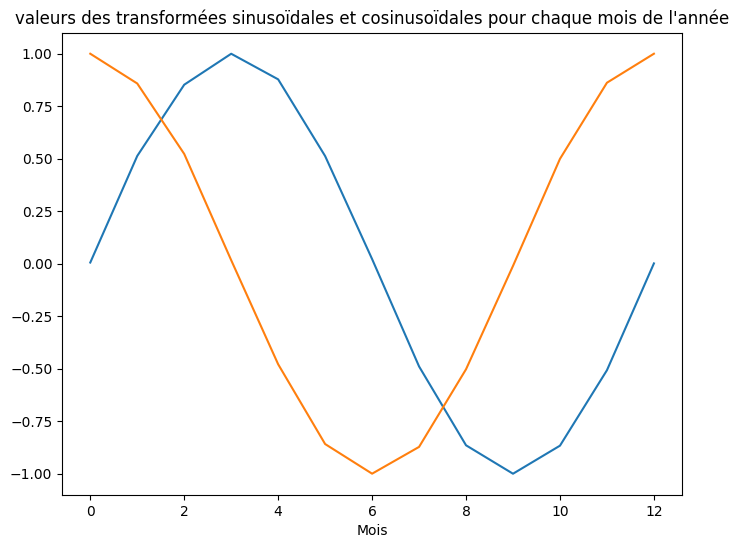

In [22]:
plt.plot(np.array(final_data['Year sin'])[:13])
plt.plot(np.array(final_data['Year cos'])[:13])
plt.xlabel('Mois')
plt.title("valeurs des transformées sinusoïdales et cosinusoïdales pour chaque mois de l'année")

In [23]:
final_data_validation = final_data[-117:]

In [24]:
final_data

,total_fuel,total_heures_travail,CA1311651,CA6T1140,CA5P8249,CA7T2283,CA7T2288,CA7G0343,CA6V1728,CA3S1349,...,10000_15000,15000_20000,20000_25000,25000_30000,30000_35000,35000_40000,40000 >,CA2782376,Year sin,Year cos
0,101482,2991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,0,0,0,0,0,0,0.0,0.005677,0.999984
1,97955,2538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,0,0,0,0,0,0,0.0,0.513246,0.858241
2,95250,2729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,0,0,0,0,0,0,0.0,0.852443,0.522820
3,92244,2415,1.0,5.0,10.0,0.0,0.0,0.0,0.0,0.0,...,7,0,0,0,0,0,0,0.0,0.999858,0.016869
4,85397,2386,0.0,0.0,0.0,4.0,86.0,672.0,4.0,0.0,...,2,5,0,0,0,0,0,10.0,0.877959,-0.478735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,56927,1787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,4,0,0,1,0,0,0.0,-0.867922,0.496700
119,76738,2409,0.0,0.0,25.0,0.0,0.0,6.0,0.0,0.0,...,2,4,1,0,1,0,0,0.0,-0.509773,0.860309
120,81778,2458,4.0,18.0,18.0,3.0,0.0,0.0,3.0,0.0,...,1,4,1,0,0,1,0,0.0,-0.001634,0.999999
121,78967,2408,0.0,0.0,0.0,0.0,0.0,50.0,0.0,3.0,...,1,3,2,0,0,1,0,0.0,0.506958,0.861971


In [25]:
final_data_cop_val = final_data[etude]

In [26]:
final_data.to_excel('final_data_with_time.xlsx', index=False)
print("Résultat exporté en Excel.")

print('Data type of each column of Dataframe :')
final_data.info(verbose=True)

Résultat exporté en Excel.
Data type of each column of Dataframe :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_fuel            123 non-null    int64  
 1   total_heures_travail  123 non-null    int64  
 2   CA1311651             123 non-null    float64
 3   CA6T1140              123 non-null    float64
 4   CA5P8249              123 non-null    float64
 5   CA7T2283              123 non-null    float64
 6   CA7T2288              123 non-null    float64
 7   CA7G0343              123 non-null    float64
 8   CA6V1728              123 non-null    float64
 9   CA3S1349              123 non-null    float64
 10  CA8T4994              123 non-null    float64
 11  CA8C6857              123 non-null    float64
 12  CA1844395             123 non-null    float64
 13  CA7H3609              123 non-null    float64
 14  1_5000 

In [27]:
final_data_validation

,total_fuel,total_heures_travail,CA1311651,CA6T1140,CA5P8249,CA7T2283,CA7T2288,CA7G0343,CA6V1728,CA3S1349,...,10000_15000,15000_20000,20000_25000,25000_30000,30000_35000,35000_40000,40000 >,CA2782376,Year sin,Year cos
6,84443,2263,32.0,64.0,45.0,4.0,0.0,0.0,0.0,24.0,...,1,6,0,0,0,0,0,0.0,0.022211,-0.999753
7,91550,2383,33.0,66.0,115.0,11.0,172.0,1013.0,8.0,25.0,...,0,7,0,0,0,0,0,10.0,-0.489113,-0.872220
8,85869,2270,32.0,63.0,150.0,10.0,0.0,0.0,6.0,21.0,...,0,7,0,0,0,0,0,10.0,-0.864603,-0.502456
9,77672,2248,33.0,70.0,75.0,0.0,6.0,0.0,6.0,30.0,...,0,6,0,0,0,0,0,10.0,-0.999946,-0.010354
10,77168,2182,1.0,0.0,0.0,2.0,85.0,672.0,2.0,0.0,...,0,7,0,0,0,0,0,10.0,-0.866359,0.499423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,56927,1787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,4,0,0,1,0,0,0.0,-0.867922,0.496700
119,76738,2409,0.0,0.0,25.0,0.0,0.0,6.0,0.0,0.0,...,2,4,1,0,1,0,0,0.0,-0.509773,0.860309
120,81778,2458,4.0,18.0,18.0,3.0,0.0,0.0,3.0,0.0,...,1,4,1,0,0,1,0,0.0,-0.001634,0.999999
121,78967,2408,0.0,0.0,0.0,0.0,0.0,50.0,0.0,3.0,...,1,3,2,0,0,1,0,0.0,0.506958,0.861971


# plot the evolution of consumption

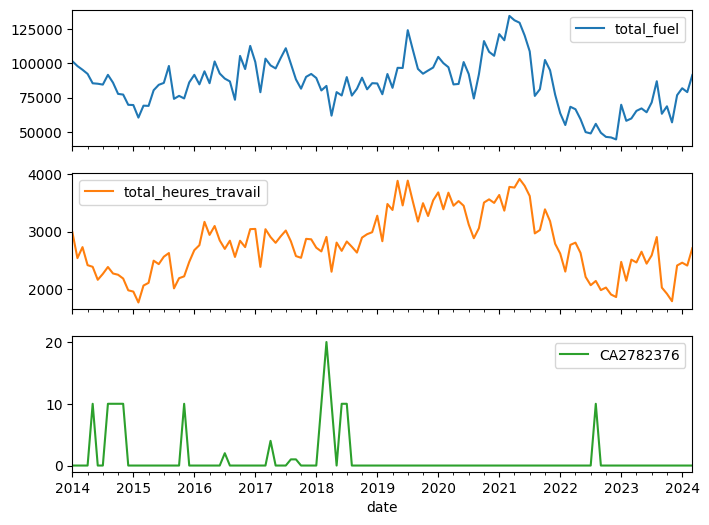

In [28]:
plot_cols = ['total_fuel', 'total_heures_travail', etude ]
plot_features = final_data[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

# Split the data

In [29]:
column_indices = {name: i for i, name in enumerate(final_data.columns)}
final_data = final_data 
n = len(final_data)
train_df = final_data[0:int(n*0.75)]
val_df = final_data[int(n*0.75):int(n*0.9)]
test_df = final_data[int(n*0.9):]

num_features = final_data.shape[1]

In [30]:
num_features

26

In [31]:
final_data[-8:]

,total_fuel,total_heures_travail,CA1311651,CA6T1140,CA5P8249,CA7T2283,CA7T2288,CA7G0343,CA6V1728,CA3S1349,...,10000_15000,15000_20000,20000_25000,25000_30000,30000_35000,35000_40000,40000 >,CA2782376,Year sin,Year cos
115,86905,2905,2.0,4.0,10.0,0.0,0.0,4.0,1.0,0.0,...,3,4,1,0,1,0,0,0.0,-0.486373,-0.873751
116,63191,2024,0.0,0.0,8.0,0.0,0.0,0.0,0.0,70.0,...,2,4,1,0,1,0,0,0.0,-0.863021,-0.505168
117,68633,1917,0.0,0.0,77.0,0.0,0.0,48.0,0.0,0.0,...,2,4,1,0,1,0,0,0.0,-0.999909,-0.013493
118,56927,1787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,4,0,0,1,0,0,0.0,-0.867922,0.496700
119,76738,2409,0.0,0.0,25.0,0.0,0.0,6.0,0.0,0.0,...,2,4,1,0,1,0,0,0.0,-0.509773,0.860309
120,81778,2458,4.0,18.0,18.0,3.0,0.0,0.0,3.0,0.0,...,1,4,1,0,0,1,0,0.0,-0.001634,0.999999
121,78967,2408,0.0,0.0,0.0,0.0,0.0,50.0,0.0,3.0,...,1,3,2,0,0,1,0,0.0,0.506958,0.861971
122,91401,2711,3.0,5.0,4.0,0.0,0.0,180.0,0.0,0.0,...,1,4,2,0,0,1,0,0.0,0.857573,0.514362


In [32]:
print('final_data_shape',final_data.shape)
print('train_df_shape',train_df.shape)
print('val_df_shape',val_df.shape)
print('test_df_shape',test_df.shape)

final_data_shape (123, 26)
train_df_shape (92, 26)
val_df_shape (18, 26)
test_df_shape (13, 26)


# Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

In [33]:
train_mean = train_df.mean()
train_std = train_df.std()

# final_data = (final_data - train_mean) / train_std
# train_df = (train_df - train_mean) / train_std
# val_df = (val_df - train_mean) / train_std
# test_df = (test_df - train_mean) / train_std

In [34]:
train_min = train_df.min()
train_max = train_df.max()


final_data = (final_data - train_min) / (train_max - train_min)
train_df = (train_df - train_min) / (train_max - train_min)
val_df = (val_df - train_min) / (train_max - train_min)
test_df = (test_df - train_min) / (train_max - train_min)

In [35]:
k = final_data.min()

In [36]:
# df_std = (final_data - train_mean) / train_std
# df_std = df_std.melt(var_name='Column', value_name='Normalized')
# plt.figure(figsize=(12, 6))
# ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
# _ = ax.set_xticklabels(final_data.keys(), rotation=90)

In [37]:
final_data

,total_fuel,total_heures_travail,CA1311651,CA6T1140,CA5P8249,CA7T2283,CA7T2288,CA7G0343,CA6V1728,CA3S1349,...,10000_15000,15000_20000,20000_25000,25000_30000,30000_35000,35000_40000,40000 >,CA2782376,Year sin,Year cos
0,0.554555,0.569967,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.502845,0.999993
1,0.506945,0.359368,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.756634,0.929118
2,0.470431,0.448164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.926235,0.761401
3,0.429854,0.302185,0.016129,0.036765,0.032362,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.999943,0.508414
4,0.337428,0.288703,0.000000,0.000000,0.000000,0.181818,0.324528,0.336673,0.133333,0.000000,...,0.285714,0.714286,0.000000,0.0,0.000000,0.0,0.0,0.5,0.938993,0.260602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,-0.046881,0.010228,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.285714,0.571429,0.000000,0.0,0.142857,0.0,0.0,0.0,0.066040,0.748340
119,0.220542,0.299396,0.000000,0.000000,0.080906,0.000000,0.000000,0.003006,0.000000,0.000000,...,0.285714,0.571429,0.142857,0.0,0.142857,0.0,0.0,0.0,0.245117,0.930152
120,0.288576,0.322176,0.064516,0.132353,0.058252,0.136364,0.000000,0.000000,0.100000,0.000000,...,0.142857,0.571429,0.142857,0.0,0.000000,0.2,0.0,0.0,0.499190,1.000000
121,0.250631,0.298931,0.000000,0.000000,0.000000,0.000000,0.000000,0.025050,0.000000,0.023256,...,0.142857,0.428571,0.285714,0.0,0.000000,0.2,0.0,0.0,0.753489,0.930983


In [38]:
# print('Data type of each column of Dataframe :')
# final_data.info(verbose=True)

# final_data.to_excel('final_data_normalised_GKT.xlsx', index=False)
# print("Résultat exporté en Excel.")

# Data windowing

### 1. Indexes and offsets



In [39]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,final_data = final_data,
               label_columns=None):
    
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.final_data = final_data

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

### 2. Split


In [40]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  # labels = labels.numpy()
  # labels = tf.multiply(labels, 1.25)
  #use tf.multiplyer with the coorect array
  # labels = tf.constant(labels)
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [41]:
def plot_old(self, model=None, plot_col=etude, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    print("-----------------------")
    print("print all inputs",inputs[n, :, :])
    print("print selected input",inputs[n, :, plot_col_index])
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{etude_print} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    print("what is the plot_col_index",plot_col_index)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
    
    print("what is the label_col_index",label_col_index)
    print("print all labels",labels[n, :, :])
    print("print selected labels",labels[n, :, label_col_index])
    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      print("print all predictions",predictions[n, :, :])
      print("print selected predictions",predictions[n, :, label_col_index])
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()
    print("-----------------------")
  plt.xlabel('Mois')

WindowGenerator.plot_old = plot_old

In [42]:
def plot(self, model=None, plot_col=etude, max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  modified_inputs = inputs.numpy()  # Convert the EagerTensor to a NumPy array
  modified_labels = labels.numpy()  # Convert the EagerTensor to a NumPy array
  months_input = ['month' + str(i) for i in range(self.input_width)]
  months_prediction = ['month' + str(i+self.input_width) for i in range(self.label_width)]
  seuil = 0.8
  
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    final_modified_predictions_integer = []
    modified_inputs[n, :, plot_col_index] = modified_inputs[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
    # modified_labels[n, :, plot_col_index] = modified_labels[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
    print("-----------------------")
    print("print all inputs",inputs[n, :, :])
    print("print all modified inputs",modified_inputs[n, :, :])
    print("print selected input",inputs[n, :, plot_col_index])
    print("print selected modified inputs ",modified_inputs[n, :, plot_col_index])
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{etude_print} [normed]')
    plt.plot(months_input, modified_inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    print("what is the plot_col_index",plot_col_index)

    # if self.label_columns:
    #   label_col_index = self.label_columns_indices.get(plot_col, None)
    # else:
    #   label_col_index = plot_col_index

    # if label_col_index is None:
    #   continue
    
    label_col_index = 0
    
    print("what is the label_col_index",label_col_index)
    print("print all labels",labels[n, :, :])
    print("print selected labels",labels[n, :, label_col_index])
    modified_labels[n, :, label_col_index] = modified_labels[n, :, label_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
    print("print selected modified labels",modified_labels[n, :, label_col_index])
    plt.scatter(months_prediction, modified_labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      modified_predictions = predictions.numpy() 
      print("print all predictions",predictions[n, :, :])
      print("print selected predictions",predictions[n, :, label_col_index])
      modified_predictions[n, :, label_col_index] = modified_predictions[n, :, label_col_index] * (train_max[etude]-train_min[etude])+ train_min[etude]
      final_modified_predictions = modified_predictions[n, :, label_col_index]
      print("print selected modified predictions",final_modified_predictions)
      
      for x in final_modified_predictions:
        if x >= math.floor(x) + seuil :
          final_modified_predictions_integer.append(math.ceil(x))
        elif 0 < x <= math.floor(x) +seuil:
          final_modified_predictions_integer.append(math.floor(x))
        else:
          final_modified_predictions_integer.append(0)
      final_modified_predictions_integer = np.array(final_modified_predictions_integer)
      print("print selected modified predictions integeres ",final_modified_predictions_integer)
      plt.scatter(months_prediction, final_modified_predictions_integer,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()
    print("-----------------------")
  plt.xlabel('Mois')

WindowGenerator.plot = plot

### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [43]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=1,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [44]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def all_data(self):
  return self.make_dataset(self.final_data)

@property
def final_prediction(self):
  return self.make_dataset_final_prediction(self.final_data)


# example and example_test are used for polots
@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.all_data))
    # And cache it for next time
    self._example = result
  return result

@property
def example_test(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.all_data = all_data
WindowGenerator.final_prediction = final_prediction
WindowGenerator.example = example
WindowGenerator.example_test = example_test

In [45]:
# dir(final_prediction)
# print(final_prediction.input_slice)
# print(final_prediction.labels_slice)
final_prediction

# compile_and_fit options

In [46]:
MAX_EPOCHS = 150

# Define a checkpoint path
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'


#takes the best model

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose=0
)

class DebugCallback(Callback):
    def __init__(self, window):
        super().__init__()
        self.window = window

    def on_epoch_end(self, epoch, logs=None):
        # Retrieve the first batch from `window.train`
        for x, y_true in self.window.train.take(114):
            # Make predictions on the first batch
            y_pred = self.model.predict(x)

            # Print or log the true and predicted values
            np.set_printoptions(precision=4, suppress=True)
            print(f"\nEnd of epoch {epoch}")
            print(f"Input tensor shape (x): {x.shape}")
            print(f"Input tensor (x): {x}")
            print(f"Targeted tensor shape (y_true): {y_true.shape}")
            print(f"Targeted tensor (y_true): {y_true}")
            print(f"Predicted tensor shape (y_pred): {y_pred.shape}\n")
            print(f"Predicted tensor (y_pred): {y_pred}\n")

initial_learning_rate = 0.0005


# debug option

def compile_and_fit_debug(model, window):
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  metrics=[tf.keras.metrics.MeanSquaredError()])

    # Create fresh instances of callbacks for each model
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=200,
                                                      mode='min',
                                                      verbose=2)



    # Instantiate your custom callback
    debug_callback = DebugCallback(window)

    history = model.fit(window.train, epochs=10,
                        validation_data=window.val,
                        callbacks=[debug_callback, model_checkpoint_callback ])

    return history

# la version finale de complilation 

def compile_and_fit(model, window):
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
                  metrics=[tf.keras.metrics.MeanSquaredError()])

    # Create fresh instances of callbacks for each model
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=20,
                                                      mode='min',
                                                      verbose=2)



    # Instantiate your custom callback
    debug_callback = DebugCallback(window)

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping,model_checkpoint_callback ])

    return history

# choose the number of inputs and outputs

In [47]:
input_width= 5
OUT_STEPS = 3

# single feature multioutput model test

### create the window

-----------------------
print all inputs tf.Tensor(
[[0.5545552  0.56996745 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.5028454  0.9999925 ]
 [0.5069451  0.35936773 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.7566337  0.9291183 ]
 [0.470431   0.44816366 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.9262346  0.7614005 ]
 [0.4298538  0.30218503 0.01612903 0.03676471 0.03236246 0.
  0.         0.         0.         0.         0.         0.
  0.19148937 0.03333334 0.       

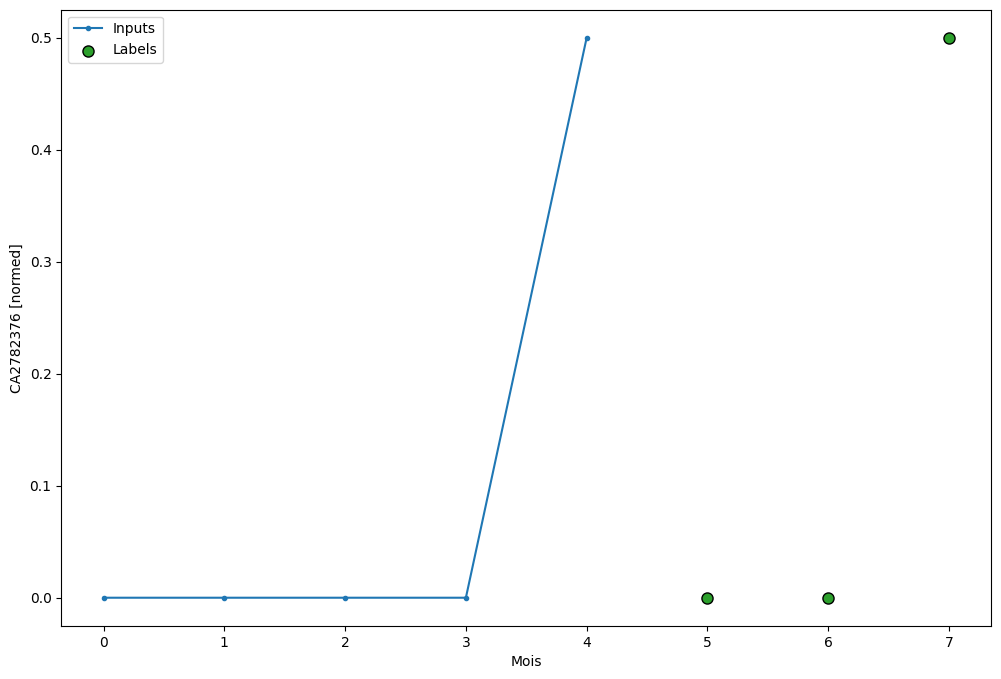

In [48]:
multi_window_one_feature = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=[etude])

multi_window_one_feature.plot_old()
multi_window_one_feature
multi_val_performance = {}
multi_performance = {}

In [49]:
for example_inputs, example_labels in multi_window_one_feature.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (1, 5, 26)
Labels shape (batch, time, features): (1, 3, 1)


### one feature output Dense

In [50]:
multi_dense_model_single_feature = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(5, num_features)),
    tf.keras.layers.Flatten(),
    # Shape => [batch, 1, dense_units]
    # tf.keras.layers.Dense(OUT_STEPS * 60 , activation='relu',kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.5)),
    tf.keras.layers.Dense(OUT_STEPS*8  , activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(OUT_STEPS *2 , activation='relu'),
    tf.keras.layers.Dropout(0.05),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,activation='sigmoid'),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])



In [51]:
history = compile_and_fit(multi_dense_model_single_feature, multi_window_one_feature)
print(history)
# IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model_single_feature.evaluate(multi_window_one_feature.val, return_dict=True)
multi_performance['Dense'] = multi_dense_model_single_feature.evaluate(multi_window_one_feature.test, verbose=0, return_dict=True)
# multi_window.plot(multi_dense_model)

Epoch 1/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1376 - mean_squared_error: 0.1376 - val_loss: 0.0766 - val_mean_squared_error: 0.0766
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0676 - mean_squared_error: 0.0676 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - val_loss: 0.0305 - val_mean_squared_error: 0.0305
Epoch 5/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0567 - mean_squared_error: 0.0567 - val_loss: 0.0291 - val_mean_squared_error: 0.0291
Epoch 6/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0288 - val_mean_squared_error: 0.0288
Epoch 7/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0285 - va

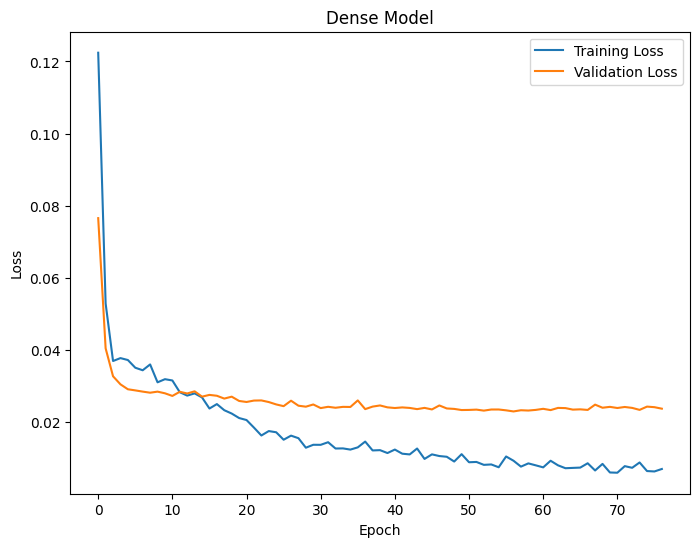

In [52]:
# Get the loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Dense Model')
plt.legend()
plt.show()

In [53]:
multi_dense_model_single_feature.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 130)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         3,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,947 (38.86 KB)

 Trainable params: 3,315 (12.95 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,632 (25.91 KB)

In [54]:
print("Conv model on `conv_window`")
print('Input shape:', multi_window_one_feature.example[0].shape)
print('Output shape:', multi_dense_model_single_feature(multi_window_one_feature.example[0]).shape)

Conv model on `conv_window`
Input shape: (1, 5, 26)
Output shape: (1, 3, 1)


-----------------------
print all inputs tf.Tensor(
[[0.5545552  0.56996745 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.5028454  0.9999925 ]
 [0.5069451  0.35936773 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.7566337  0.9291183 ]
 [0.470431   0.44816366 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.9262346  0.7614005 ]
 [0.4298538  0.30218503 0.01612903 0.03676471 0.03236246 0.
  0.         0.         0.         0.         0.         0.
  0.19148937 0.03333334 0.       

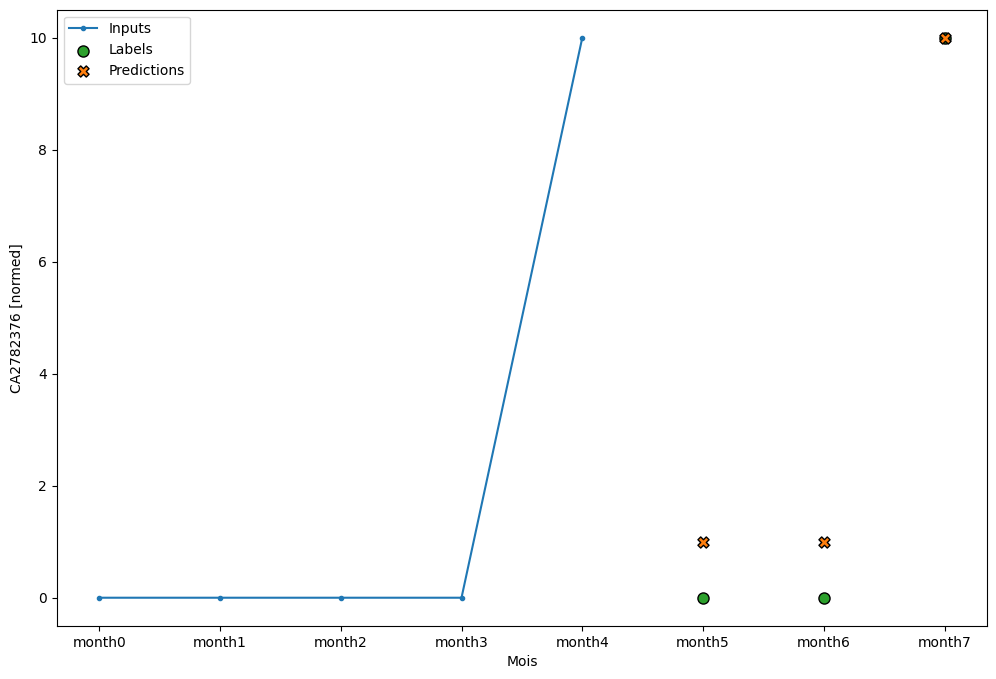

In [55]:
multi_window_one_feature.plot(multi_dense_model_single_feature)

### One feature output CNN

In [56]:
CONV_WIDTH = input_width
multi_conv_model_one_feature = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    # tf.keras.layers.Lambda(lambda x: tf.keras.backend.expand_dims(x[:, -CONV_WIDTH:, :], axis=1)),
    # tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Input(shape=(5, num_features)),
    tf.keras.layers.Conv1D(8, activation='relu', kernel_size=(CONV_WIDTH)),
    
    # tf.keras.layers.Dropout(0.1),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS,activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS,activation='sigmoid'),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_conv_model_one_feature, multi_window_one_feature)

# IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model_one_feature.evaluate(multi_window_one_feature.val, return_dict=True)
multi_performance['Conv'] = multi_conv_model_one_feature.evaluate(multi_window_one_feature.test, verbose=0, return_dict=True)

# multi_window.plot(multi_conv_model)

Epoch 1/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1931 - mean_squared_error: 0.1931 - val_loss: 0.2184 - val_mean_squared_error: 0.2184
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1838 - mean_squared_error: 0.1838 - val_loss: 0.2099 - val_mean_squared_error: 0.2099
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1768 - mean_squared_error: 0.1768 - val_loss: 0.2017 - val_mean_squared_error: 0.2017
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1700 - mean_squared_error: 0.1700 - val_loss: 0.1939 - val_mean_squared_error: 0.1939
Epoch 5/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1637 - mean_squared_error: 0.1637 - val_loss: 0.1864 - val_mean_squared_error: 0.1864
Epoch 6/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1575 - mean_squared_error: 0.1575 - val_loss: 0.1792 - val_mean_squared_error: 0.1792
Epoch 7/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1516 - mean_squared_error: 0.1516 - val_loss: 0.1722 - va

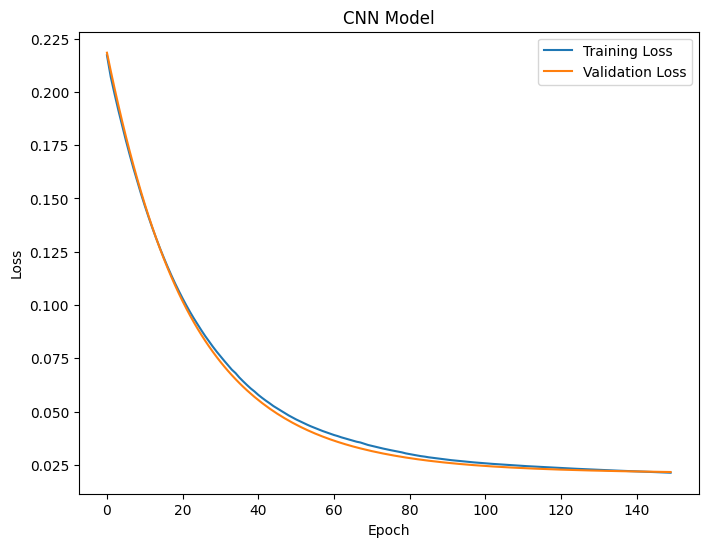

In [57]:
# Get the loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Model')
plt.legend()
plt.show()

In [58]:
multi_conv_model_one_feature.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 8)           │         1,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1, 3)           │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1, 3)           │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 3, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,263 (12.75 KB)

 Trainable params: 1,087 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,176 (8.50 KB)

In [59]:
print("Conv model on `conv_window`")
print('Input shape:', multi_window_one_feature.example[0].shape)
print('Output shape:', multi_conv_model_one_feature(multi_window_one_feature.example[0]).shape)

Conv model on `conv_window`
Input shape: (1, 5, 26)
Output shape: (1, 3, 1)


-----------------------
print all inputs tf.Tensor(
[[0.5545552  0.56996745 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.5028454  0.9999925 ]
 [0.5069451  0.35936773 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.7566337  0.9291183 ]
 [0.470431   0.44816366 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.9262346  0.7614005 ]
 [0.4298538  0.30218503 0.01612903 0.03676471 0.03236246 0.
  0.         0.         0.         0.         0.         0.
  0.19148937 0.03333334 0.       

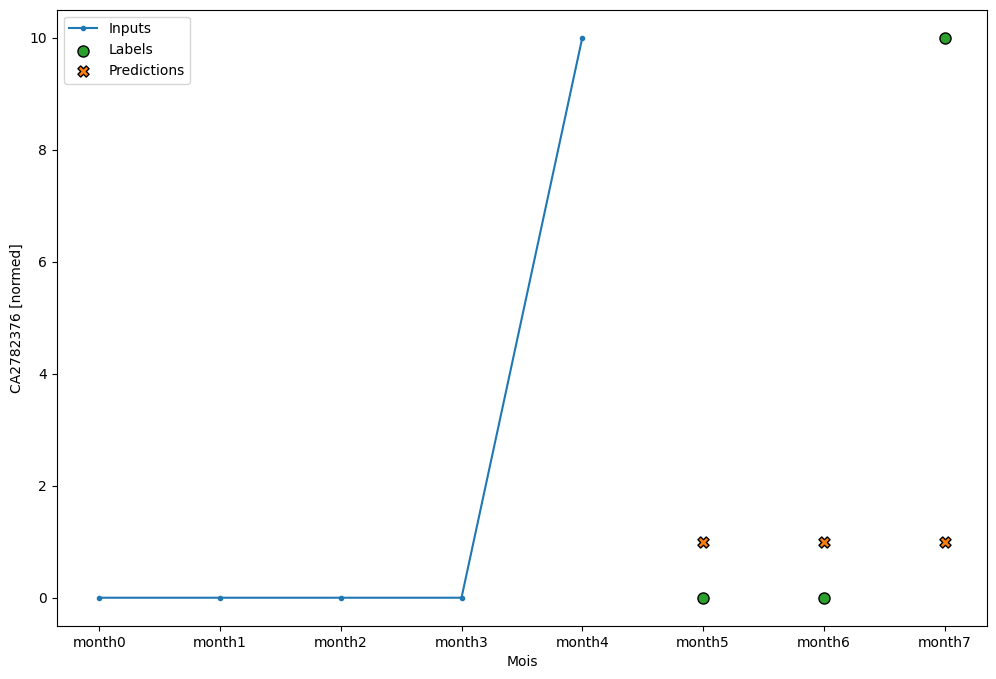

In [60]:
multi_window_one_feature.plot(multi_conv_model_one_feature)

### one feature GRU model

In [61]:
multi_gru_model_one_feature = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Input(shape=(5, num_features)),
    tf.keras.layers.GRU(8, return_sequences=False),
    
    tf.keras.layers.Dense(OUT_STEPS *4 , activation='relu'),

    tf.keras.layers.Dense(OUT_STEPS *2 , activation='relu'),
    
    # tf.keras.layers.Dense(128, activation='relu'),

    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS,activation='sigmoid',),

    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_gru_model_one_feature, multi_window_one_feature)

# IPython.display.clear_output()

multi_val_performance['GRU'] = multi_gru_model_one_feature.evaluate(multi_window_one_feature.val, return_dict=True)
multi_performance['GRU'] = multi_gru_model_one_feature.evaluate(multi_window_one_feature.test, verbose=0, return_dict=True)
# multi_window.plot(multi_lstm_model)

Epoch 1/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1906 - mean_squared_error: 0.1906 - val_loss: 0.2152 - val_mean_squared_error: 0.2152
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1790 - mean_squared_error: 0.1790 - val_loss: 0.2036 - val_mean_squared_error: 0.2036
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1682 - mean_squared_error: 0.1682 - val_loss: 0.1912 - val_mean_squared_error: 0.1912
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1576 - mean_squared_error: 0.1576 - val_loss: 0.1786 - val_mean_squared_error: 0.1786
Epoch 5/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1473 - mean_squared_error: 0.1473 - val_loss: 0.1663 - val_mean_squared_error: 0.1663
Epoch 6/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1375 - mean_squared_error: 0.1375 - val_loss: 0.1544 - val_mean_squared_error: 0.1544
Epoch 7/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1282 - mean_squared_error: 0.1282 - val_loss: 0.1432 - va

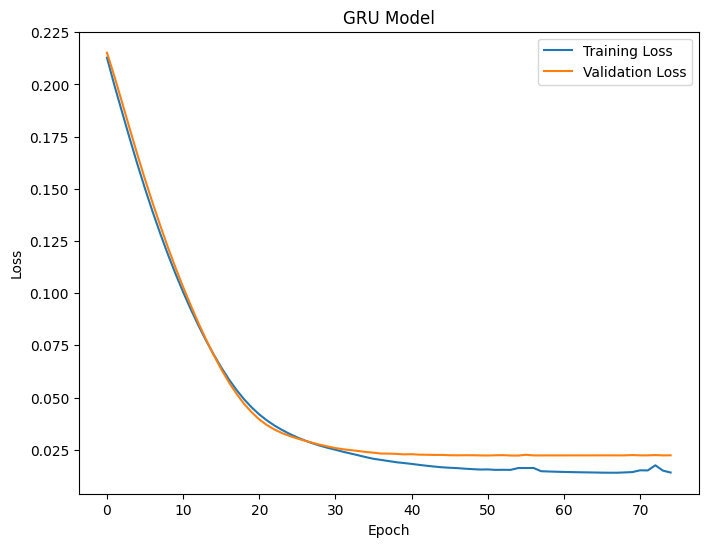

In [62]:
# Get the loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU Model')
plt.legend()
plt.show()

In [63]:
multi_gru_model_one_feature.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 8)              │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 12)             │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 3, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,215 (12.56 KB)

 Trainable params: 1,071 (4.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,144 (8.38 KB)

In [64]:
print("Conv model on `conv_window`")
print('Input shape:', multi_window_one_feature.example[0].shape)
print('Output shape:', multi_gru_model_one_feature(multi_window_one_feature.example[0]).shape)

Conv model on `conv_window`
Input shape: (1, 5, 26)
Output shape: (1, 3, 1)


-----------------------
print all inputs tf.Tensor(
[[0.5545552  0.56996745 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.5028454  0.9999925 ]
 [0.5069451  0.35936773 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.7566337  0.9291183 ]
 [0.470431   0.44816366 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.9262346  0.7614005 ]
 [0.4298538  0.30218503 0.01612903 0.03676471 0.03236246 0.
  0.         0.         0.         0.         0.         0.
  0.19148937 0.03333334 0.       

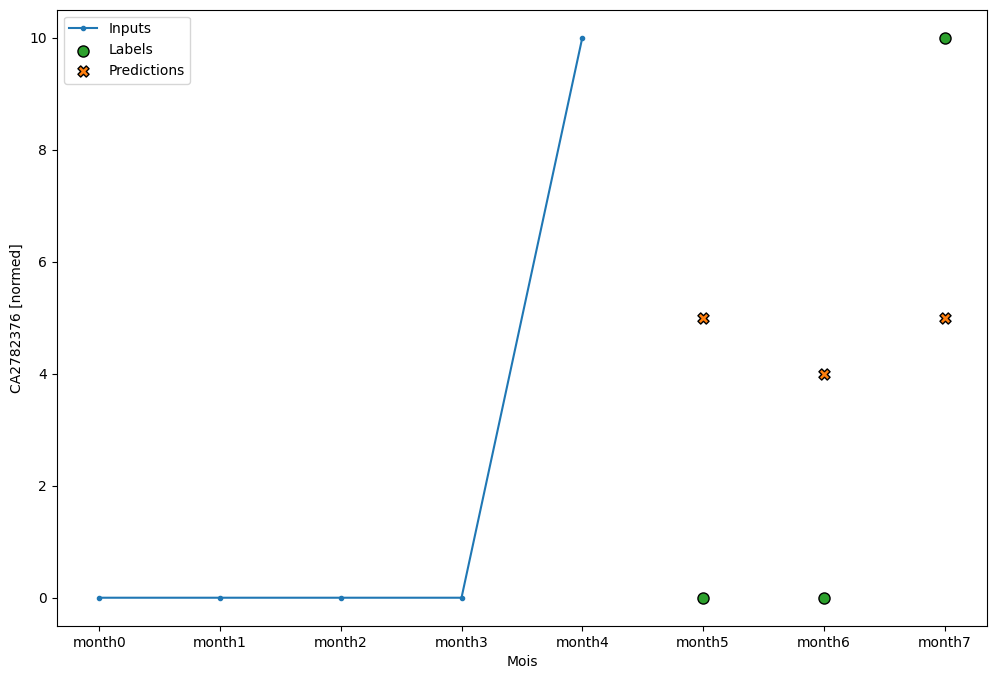

In [65]:
multi_window_one_feature.plot(multi_gru_model_one_feature)

### one feature LSTM model

In [66]:
multi_lstm_model_one_feature = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Input(shape=(5, num_features)),
    tf.keras.layers.LSTM(8, return_sequences=False),
    
    tf.keras.layers.Dense(OUT_STEPS * 8, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS * 4, activation='relu'),
    
    # tf.keras.layers.Dense(128, activation='relu'),

    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS,activation='sigmoid',),

    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_lstm_model_one_feature, multi_window_one_feature)

# IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model_one_feature.evaluate(multi_window_one_feature.val, return_dict=True)
multi_performance['LSTM'] = multi_lstm_model_one_feature.evaluate(multi_window_one_feature.test, verbose=0, return_dict=True)
# multi_window.plot(multi_lstm_model)

Epoch 1/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1907 - mean_squared_error: 0.1907 - val_loss: 0.2042 - val_mean_squared_error: 0.2042
Epoch 2/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1605 - mean_squared_error: 0.1605 - val_loss: 0.1353 - val_mean_squared_error: 0.1353
Epoch 3/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0901 - mean_squared_error: 0.0901 - val_loss: 0.0494 - val_mean_squared_error: 0.0494
Epoch 4/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0505 - mean_squared_error: 0.0505 - val_loss: 0.0300 - val_mean_squared_error: 0.0300
Epoch 5/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0484 - mean_squared_error: 0.0484 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 6/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0488 - mean_squared_error: 0.0488 - val_loss: 0.0250 - val_mean_squared_error: 0.0250
Epoch 7/150
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0487 - mean_squared_error: 0.0487 - val_loss: 0.0247 - va

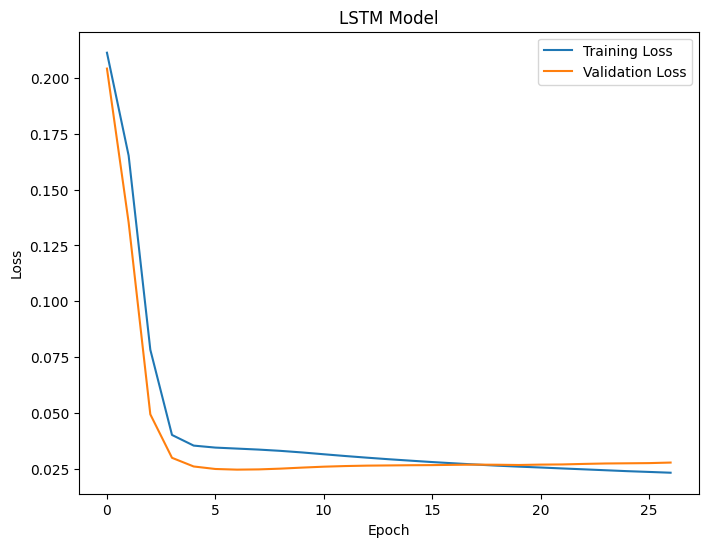

In [67]:
# Get the loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss values
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Model')
plt.legend()
plt.show()

In [68]:
multi_lstm_model_one_feature.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8)              │         1,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 24)             │           216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 3, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,027 (19.64 KB)

 Trainable params: 1,675 (6.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,352 (13.10 KB)

In [69]:
print("Conv model on `conv_window`")
print('Input shape:', multi_window_one_feature.example[0].shape)
print('Output shape:', multi_lstm_model_one_feature(multi_window_one_feature.example[0]).shape)

Conv model on `conv_window`
Input shape: (1, 5, 26)
Output shape: (1, 3, 1)


-----------------------
print all inputs tf.Tensor(
[[0.5545552  0.56996745 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.5028454  0.9999925 ]
 [0.5069451  0.35936773 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.7566337  0.9291183 ]
 [0.470431   0.44816366 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.9262346  0.7614005 ]
 [0.4298538  0.30218503 0.01612903 0.03676471 0.03236246 0.
  0.         0.         0.         0.         0.         0.
  0.19148937 0.03333334 0.       

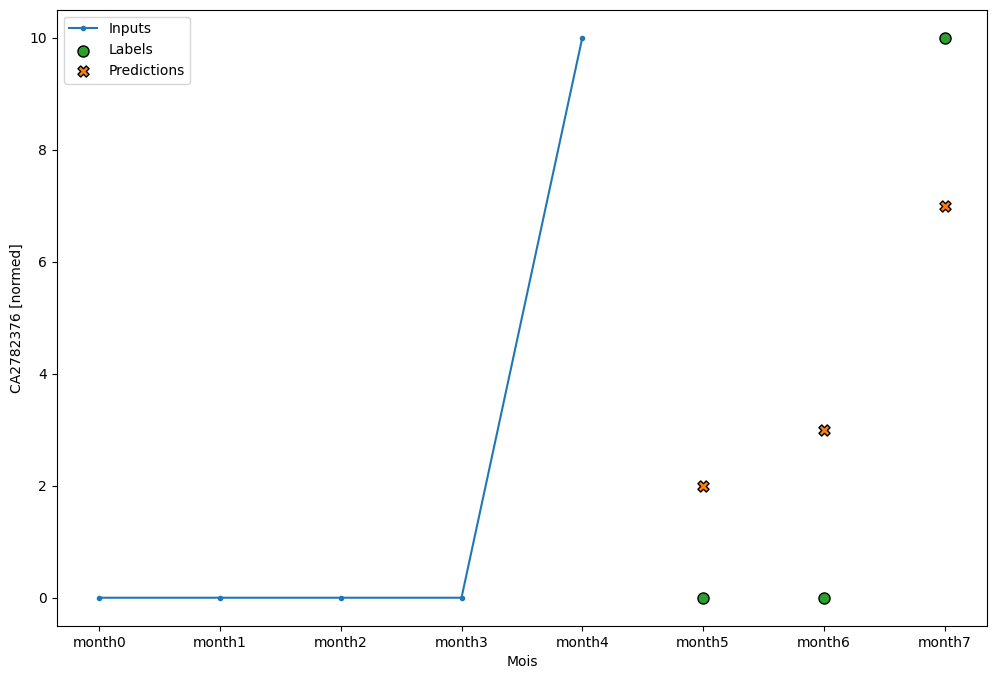

In [70]:
multi_window_one_feature.plot(multi_lstm_model_one_feature)

# Performance

In [71]:
cm = multi_conv_model_one_feature.metrics[1]
cm.metrics

[<MeanSquaredError name=mean_squared_error>]

There are clearly diminishing returns as a function of model complexity on this problem:

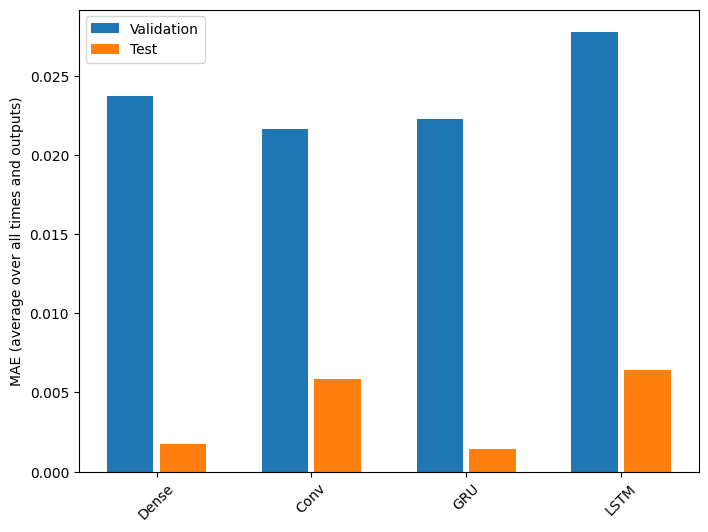

In [72]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_squared_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)

plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

# import the best model and use it

### load the best model and verify it

In [73]:
best_model = keras.models.load_model(checkpoint_filepath, safe_mode=False)

In [74]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 8)           │         1,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1, 3)           │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1, 3)           │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 3, 1)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,263 (12.75 KB)

 Trainable params: 1,087 (4.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,176 (8.50 KB)

-----------------------
print all inputs tf.Tensor(
[[0.5545552  0.56996745 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.5028454  0.9999925 ]
 [0.5069451  0.35936773 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.7566337  0.9291183 ]
 [0.470431   0.44816366 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.9262346  0.7614005 ]
 [0.4298538  0.30218503 0.01612903 0.03676471 0.03236246 0.
  0.         0.         0.         0.         0.         0.
  0.19148937 0.03333334 0.       

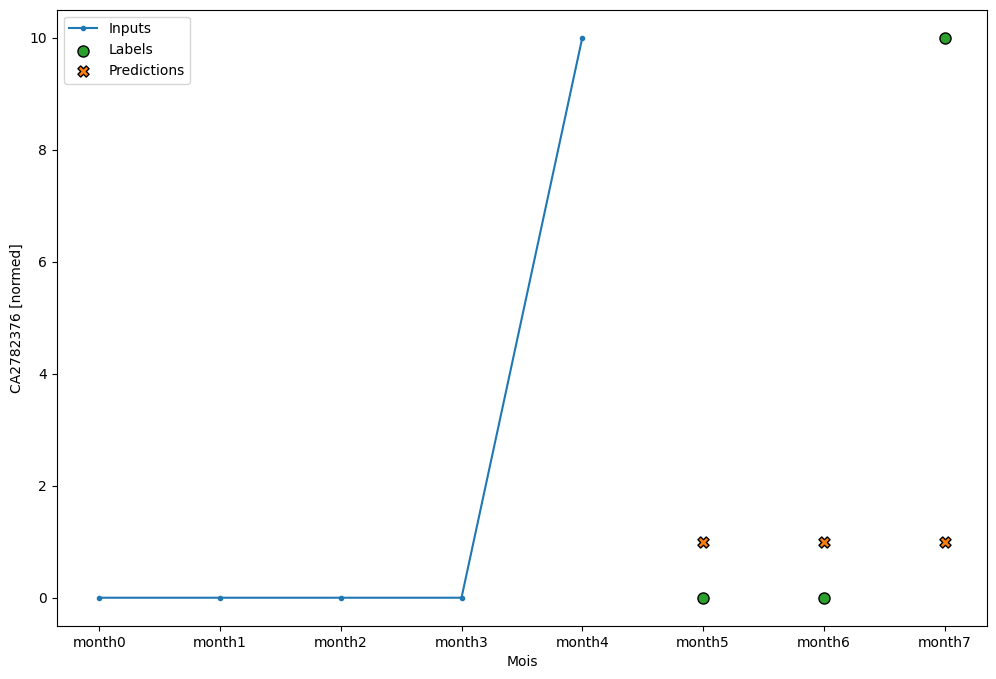

In [75]:
multi_window_one_feature.plot(best_model)

### plot the new performance

In [76]:
multi_val_performance['BEST'] = best_model.evaluate(multi_window_one_feature.val, return_dict=True)
multi_performance['BEST'] = best_model.evaluate(multi_window_one_feature.test, verbose=0, return_dict=True)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0180 - mean_squared_error: 0.0180  


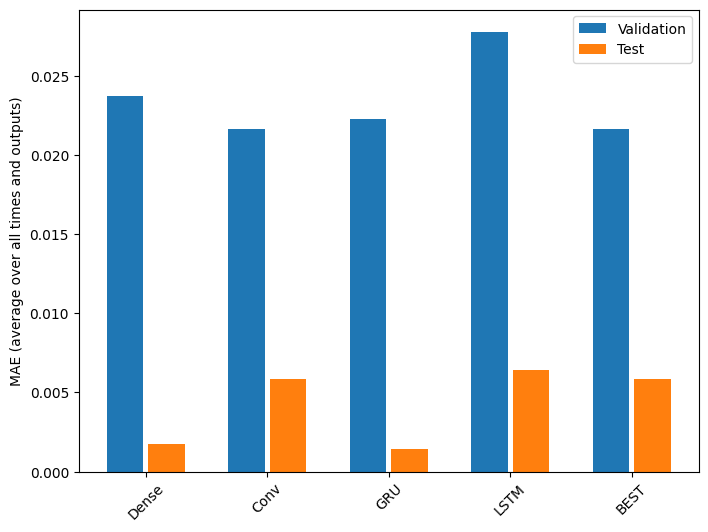

In [77]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_squared_error'
val_mae = [v[metric_name] for v in multi_val_performance.values()]
test_mae = [v[metric_name] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)

plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

### Plot on the last 5 months and the forecast on 3 months

In [78]:
# data_test = final_data[-(input_width + OUT_STEPS ):]
data_test = final_data[-(input_width + OUT_STEPS ):]

print(data_test.shape)
last_prediction = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,final_data = data_test,label_columns=[etude] )

# last_prediction.plot_old()

# last_prediction.plot()
# last_prediction

(8, 26)


In [79]:
print(data_test) #need to verify it

     total_fuel  total_heures_travail  CA1311651  CA6T1140  CA5P8249  \
115    0.357784              0.529986   0.032258  0.029412  0.032362   
116    0.037675              0.120409   0.000000  0.000000  0.025890   
117    0.111135              0.070665   0.000000  0.000000  0.249191   
118   -0.046881              0.010228   0.000000  0.000000  0.000000   
119    0.220542              0.299396   0.000000  0.000000  0.080906   
120    0.288576              0.322176   0.064516  0.132353  0.058252   
121    0.250631              0.298931   0.000000  0.000000  0.000000   
122    0.418474              0.439795   0.048387  0.036765  0.012945   

     CA7T2283  CA7T2288  CA7G0343  CA6V1728  CA3S1349  ...  10000_15000  \
115  0.000000       0.0  0.002004  0.033333  0.000000  ...     0.428571   
116  0.000000       0.0  0.000000  0.000000  0.542636  ...     0.285714   
117  0.000000       0.0  0.024048  0.000000  0.000000  ...     0.285714   
118  0.000000       0.0  0.000000  0.000000  0.0000

-----------------------
print all inputs tf.Tensor(
[[ 3.57784033e-01  5.29986024e-01  3.22580636e-02  2.94117648e-02
   3.23624611e-02  0.00000000e+00  0.00000000e+00  2.00400804e-03
   3.33333351e-02  0.00000000e+00  9.94475111e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.28571433e-01  5.71428597e-01  1.42857149e-01  0.00000000e+00
   1.42857149e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.56817102e-01  6.30857050e-02]
 [ 3.76749784e-02  1.20409109e-01  0.00000000e+00  0.00000000e+00
   2.58899685e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  5.42635679e-01  5.52486181e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.85714298e-01  5.71428597e-01  1.42857149e-01  0.00000000e+00
   1.42857149e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.84902593e-02  2.47385085e-01]
 [ 1.11135110e-01  7.06648082e-02  0.00000000e+00  0.00000000e+00
   2.49190941e-01  0

Text(0.5, 1.0, 'CA2782376')

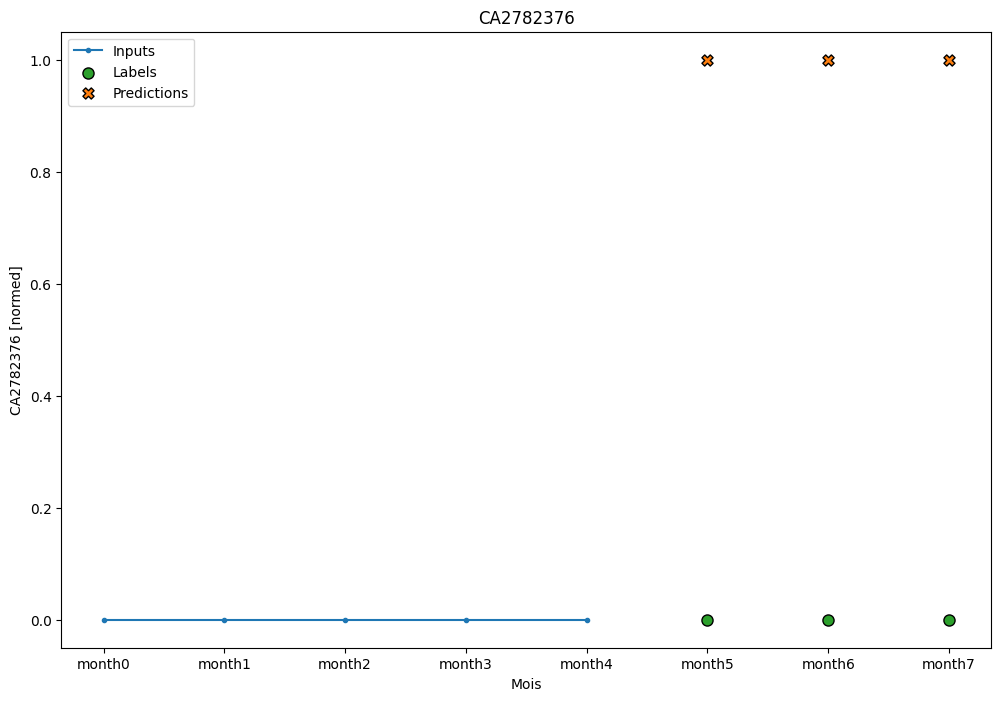

In [80]:
last_prediction.plot(best_model) #add new plot with the correct months
plt.title(etude)

### plot 3 months into the future

In [81]:
def plot_final_prediction(self,model=best_model,plot_col=etude,):
    plt.figure(figsize=(12, 8))
    seuil = 0.8
    final_data_intern = self.final_data 
    # OUT_STEPS = 3
    # plot_col_index = 8
    plot_col_index = self.column_indices[plot_col]
    data_final_plot = final_data_intern[-self.input_width:]
    data_final_plot = np.array(data_final_plot, dtype=np.float32)
    tensor_data = tf.convert_to_tensor(data_final_plot, dtype=tf.float32)
    tensor_data = tf.expand_dims(tensor_data, 0)  # Reshape tensor_data to match the model's input shape
    print("input tensor shape",tensor_data[0, :, :].shape)
    print("input tensor",tensor_data[0, :, :])
    modified_inputs = tensor_data.numpy()  # Convert the EagerTensor to a NumPy array
    modified_inputs[0, :, plot_col_index] = modified_inputs[0, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
    print("print all modified inputs",modified_inputs[0, :, :])
    print("print selected modified inputs ",modified_inputs[0, :, plot_col_index])

    # if self.label_columns:
    #   label_col_index = self.label_columns_indices.get(plot_col, None)
    # else:
    #   label_col_index = plot_col_index

    # Understand this part of the code

    label_col_index = 0
    
    print('label_col_index',label_col_index)
    predictions = model(tensor_data)
    print("predictions tensor shape",predictions.shape)
    print("predictions tensor",predictions)

    modified_predictions=[]
    
    modified_predictions = predictions.numpy()  # Convert the EagerTensor to a NumPy array
    modified_predictions[0, :, label_col_index] = modified_predictions[0, :, label_col_index] * (train_max[etude]-train_min[etude])+ train_min[etude]
    final_modified_predictions = modified_predictions[0, :, label_col_index]
    print("print selected modified predictions",final_modified_predictions)
    final_modified_predictions_integer = []

    for x in final_modified_predictions:
        if x >= math.floor(x) + seuil :
          final_modified_predictions_integer.append(math.ceil(x))
        elif 0 < x <= math.floor(x) +seuil:
          final_modified_predictions_integer.append(math.floor(x))
        else:
          final_modified_predictions_integer.append(0)
    final_modified_predictions_integer = np.array(final_modified_predictions_integer)

    
    print("print selected modified predictions integeres ",final_modified_predictions_integer)



    targeted_date = month_year[-self.input_width:]
    targeted_date = np.array(targeted_date)

    # Convert the last date in targeted_date back to datetime format
    last_date = datetime.datetime.strptime(targeted_date[-1], '%Y-%m')

    # Calculate the next 3 dates
    next_dates = [last_date + relativedelta(months=i) for i in range(1, self.label_width+1)]

    # Convert the next_dates to the desired format
    next_dates_formatted = [date.strftime('%Y-%m') for date in next_dates]

    # Extend the targeted_date list with the next_dates_formatted
    targeted_date = np.concatenate((targeted_date, next_dates_formatted))
    print("targeted_date",targeted_date)


    plt.plot(targeted_date[0:input_width], modified_inputs[0, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    plt.scatter(targeted_date[input_width:input_width + OUT_STEPS], final_modified_predictions_integer,
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)
    plt.legend()
    plt.xlabel('Mois')


WindowGenerator.plot_final_prediction = plot_final_prediction

input tensor shape (5, 26)
input tensor tf.Tensor(
[[-0.04688112  0.0102278   0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.2857143   0.5714286
   0.          0.          0.14285715  0.          0.          0.
   0.06603961  0.74834013]
 [ 0.22054239  0.29939562  0.          0.          0.08090615  0.
   0.          0.00300601  0.          0.          0.11049724  0.08988764
   0.17021276  0.          0.          0.          0.2857143   0.5714286
   0.14285715  0.          0.14285715  0.          0.          0.
   0.245117    0.93015224]
 [ 0.288576    0.32217574  0.06451613  0.13235295  0.05825243  0.13636364
   0.          0.          0.1         0.          0.07734807  0.07865169
   0.07446808  0.          0.          0.          0.14285715  0.5714286
   0.14285715  0.          0.          0.2         0.          0.
   0.49918976  0.9999999 ]
 [ 0.25063106  0.29893073  0.  

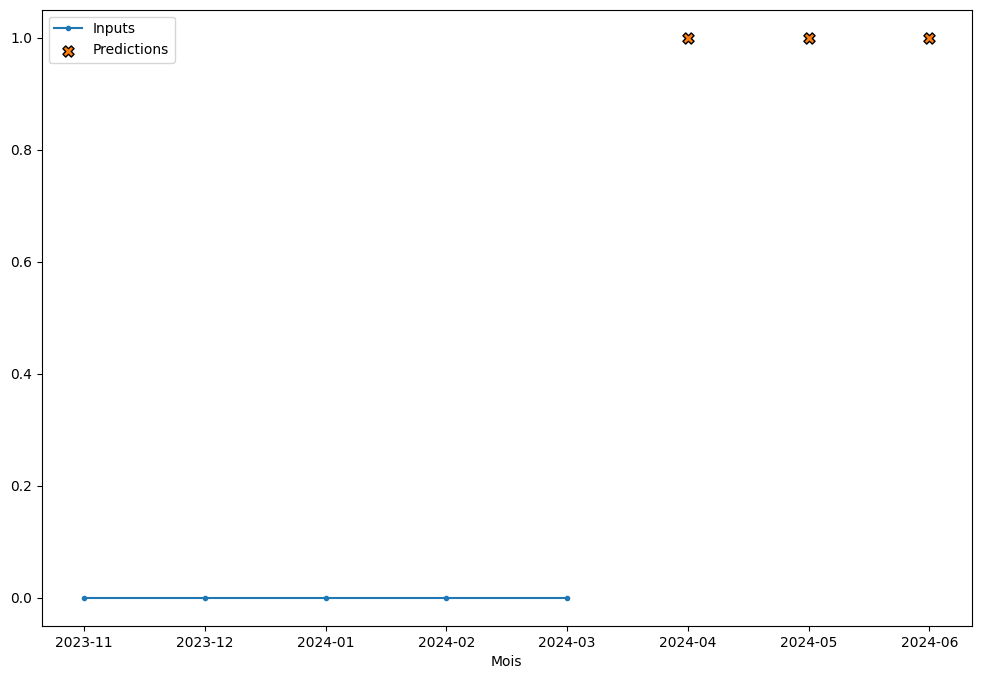

In [82]:
last_prediction.plot_final_prediction()

### validate the model from 2020 

In [83]:
def final_val(self, model=best_model, plot_col=etude):
  inputs, labels = self.example
  modified_inputs = inputs.numpy()  # Convert the EagerTensor to a NumPy array
  modified_labels = labels.numpy()  # Convert the EagerTensor to a NumPy array
  seuil = 0.8
  
  plot_col_index = self.column_indices[plot_col]
   
  final_modified_predictions_integer = []
  modified_inputs[0, :, plot_col_index] = modified_inputs[0, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
  # modified_labels[n, :, plot_col_index] = modified_labels[n, :, plot_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
  print("-----------------------")
  print("raw input shape",inputs.shape)
  print("print all inputs",inputs[0, :, :])
  print("print all modified inputs",modified_inputs[0, :, :])
  print("print selected input",inputs[0, :, plot_col_index])
  print("print selected modified inputs ",modified_inputs[0, :, plot_col_index])
  print("what is the plot_col_index",plot_col_index)

  label_col_index = 0  
  print("what is the label_col_index",label_col_index)
  print("raw labels shape",labels.shape)
  print("print all labels",labels[0, :, :])
  print("print selected labels",labels[0, :, label_col_index])
  modified_labels[0, :, label_col_index] = modified_labels[0, :, label_col_index] * (train_max[etude]-train_min[etude]) + train_min[etude]
  print("print selected modified labels",modified_labels[0, :, label_col_index])


  evaluate_col_index = 0
  if model is not None:
    predictions = model(inputs)
    modified_predictions = predictions.numpy()
    print("raw predictions shape",predictions.shape) 
    print("print all predictions",predictions[:, :, :])
    print("print selected predictions",predictions[0, :, evaluate_col_index])
    modified_predictions[0, :, evaluate_col_index] = modified_predictions[0, :, evaluate_col_index] * (train_max[etude]-train_min[etude])+ train_min[etude]
    final_modified_predictions = modified_predictions[0, :, evaluate_col_index]
    print("print selected modified predictions",final_modified_predictions)
    
    for x in final_modified_predictions:
      if x >= math.floor(x) + seuil :
        final_modified_predictions_integer.append(math.ceil(x))
      elif 0 < x <= math.floor(x) +seuil:
        final_modified_predictions_integer.append(math.floor(x))
      else:
        final_modified_predictions_integer.append(0)
    final_modified_predictions_integer = np.array(final_modified_predictions_integer)
    final_modified_predictions = np.array(final_modified_predictions)
    print("print selected modified predictions integeres ",final_modified_predictions_integer)
    return(final_modified_predictions,final_modified_predictions_integer)

WindowGenerator.final_val = final_val

In [84]:
# Initialize a counter
s = 0
# Iterate over the DataFrame in steps of 3, starting from the end
# print(len(final_data))
finalpred=[]
finalpred_transformed=[]
for i in range(len(final_data) - 3, 5, -3):
    s += 1
    # Create a (3,3) submatrix (sub-DataFrame) with the current and two preceding rows
    print("i",i)
    submatrix = final_data.iloc[i-5:i+3]    
    last_prediction = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,final_data = submatrix,label_columns=[etude] )
    print("iteration",s)
    # print(submatrix)
    pred,pred2 = last_prediction.final_val(multi_lstm_model_one_feature)
    print("---------------------")
    finalpred = np.concatenate((pred, finalpred))
    finalpred_transformed = np.concatenate((pred2, finalpred_transformed))
    # if(i <= 72):
    #     break
print("///////////////////////////////////")
print("final prediction array without transformation",finalpred)
print("final prediction array with transformation",finalpred_transformed)


i 120
iteration 1
-----------------------
raw input shape (1, 5, 26)
print all inputs tf.Tensor(
[[ 3.57784033e-01  5.29986024e-01  3.22580636e-02  2.94117648e-02
   3.23624611e-02  0.00000000e+00  0.00000000e+00  2.00400804e-03
   3.33333351e-02  0.00000000e+00  9.94475111e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.28571433e-01  5.71428597e-01  1.42857149e-01  0.00000000e+00
   1.42857149e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.56817102e-01  6.30857050e-02]
 [ 3.76749784e-02  1.20409109e-01  0.00000000e+00  0.00000000e+00
   2.58899685e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  5.42635679e-01  5.52486181e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.85714298e-01  5.71428597e-01  1.42857149e-01  0.00000000e+00
   1.42857149e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
   6.84902593e-02  2.47385085e-01]
 [ 1.11135110e-01  7.06648082e-02  0.0000

In [85]:
finalpred.shape

(117,)

In [86]:
finalpred_transformed

array([ 5.,  6., 10.,  9.,  7.,  5.,  3.,  2.,  2.,  1.,  1.,  1.,  1.,
        2.,  2.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,
        4.,  4.,  3.,  4.,  3.,  2.,  5.,  4.,  3.,  4.,  4.,  3.,  2.,
        1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  2.,  2.,  4.,  1.,  1.,
        2.,  0.,  0.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  1.,  1.,  1.])

### plot for each month

In [87]:
final_data_cop_val[6:123]

6       0.0
7      10.0
8      10.0
9      10.0
10     10.0
       ... 
118     0.0
119     0.0
120     0.0
121     0.0
122     0.0
Name: CA2782376, Length: 117, dtype: float64

In [88]:
months = [ str(i) for i in range(117)]

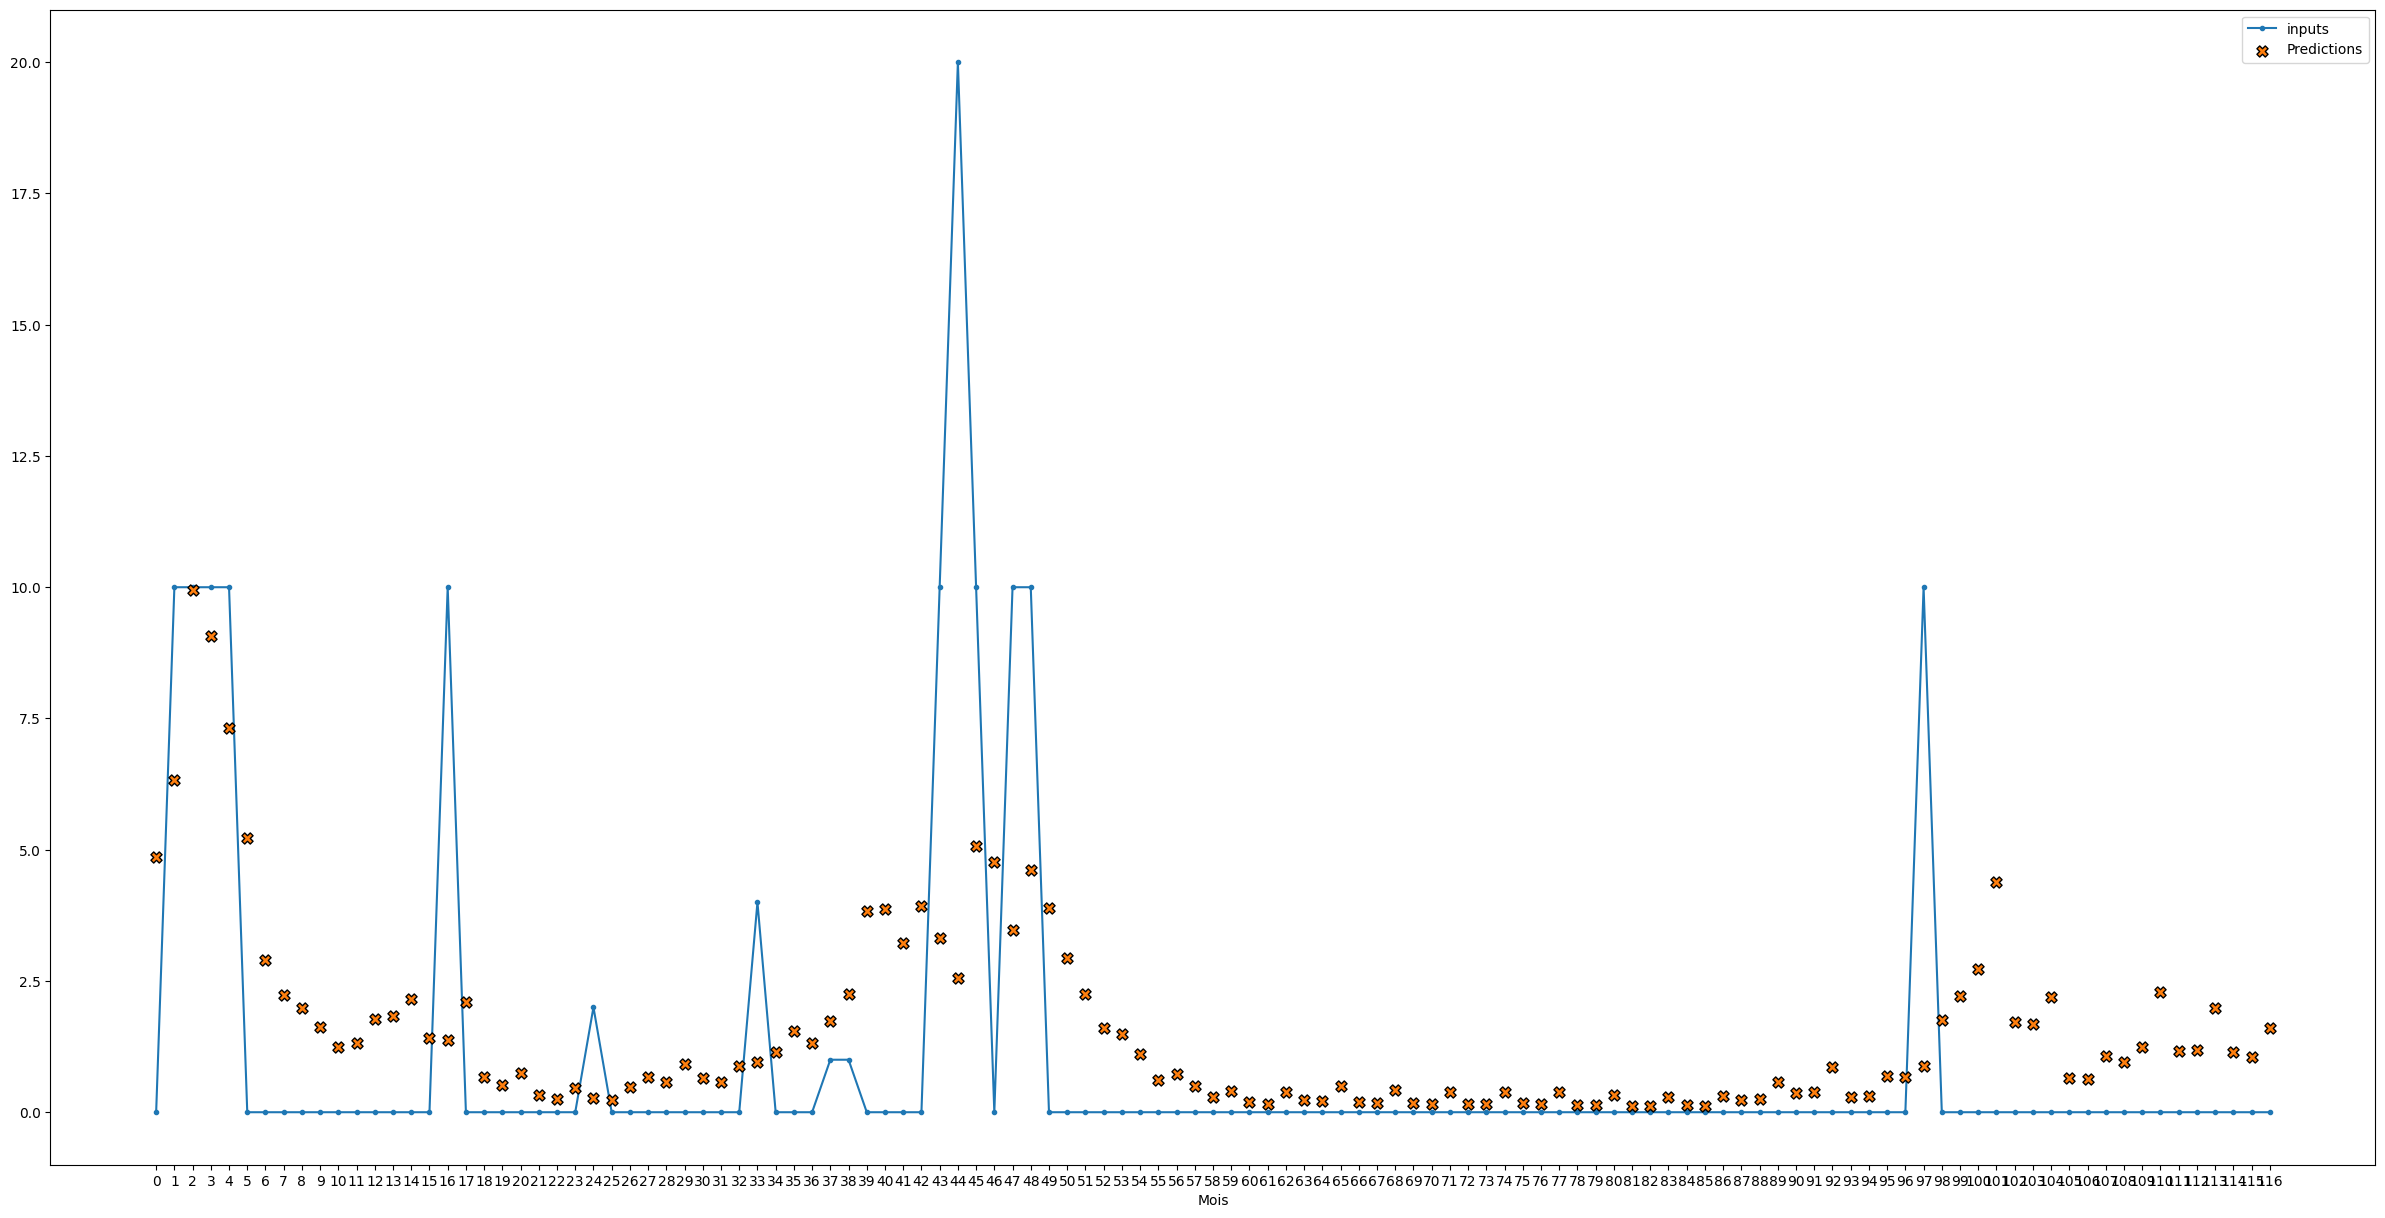

In [89]:
plt.figure(figsize=(30, 15))
plt.plot(months, final_data_cop_val[6:123],
             label='inputs', marker='.', zorder=-10)


plt.scatter(months, finalpred,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)


plt.xlabel('Mois')
plt.legend()

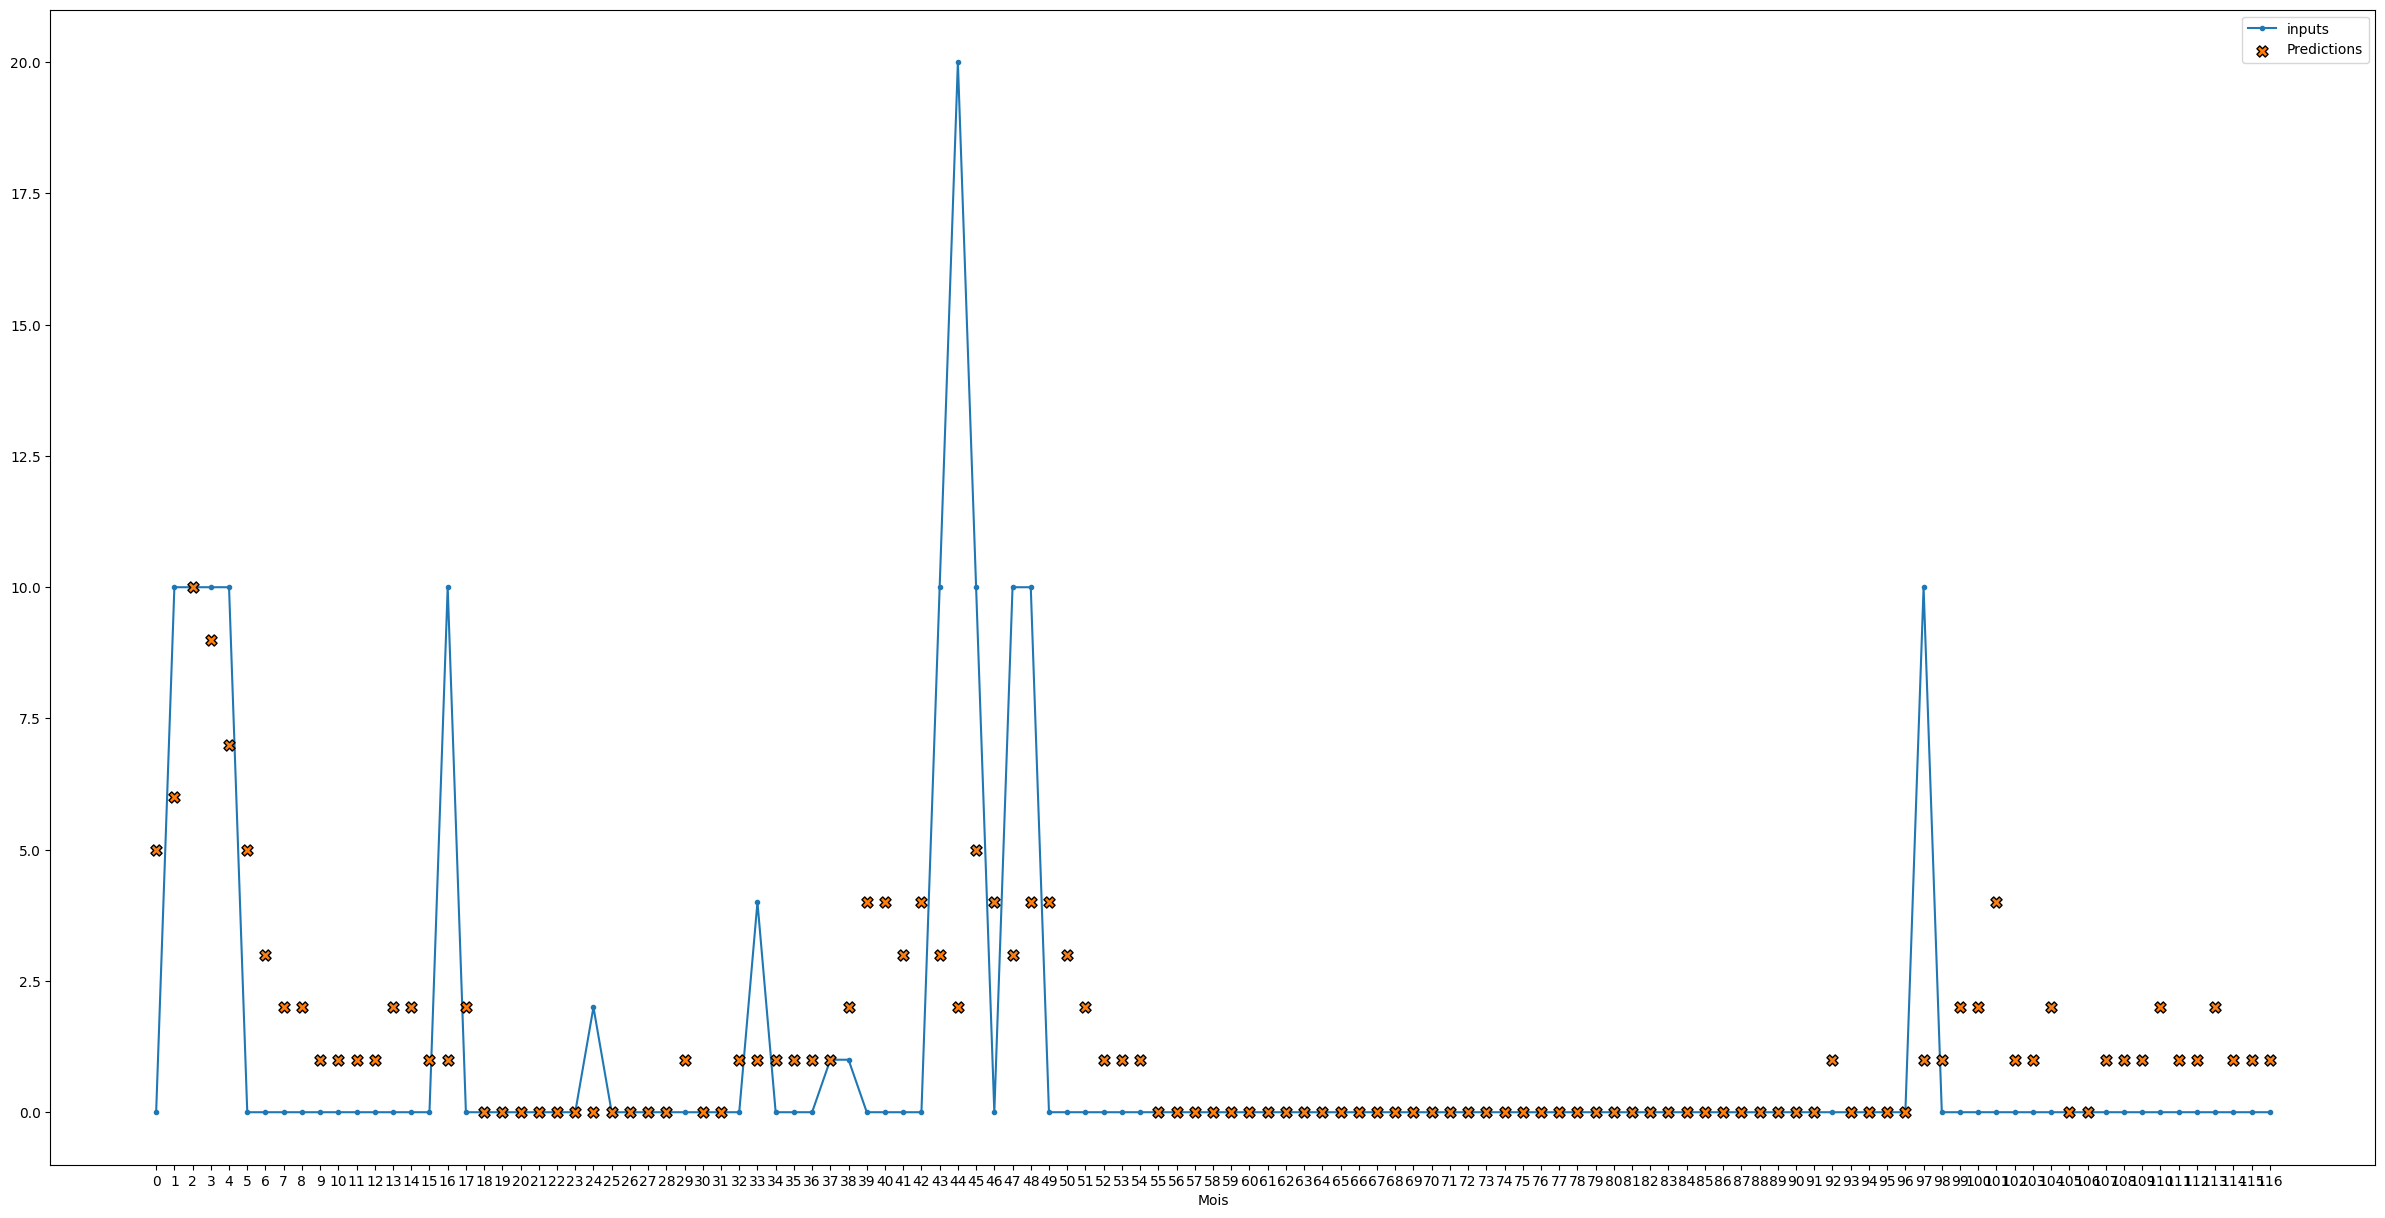

In [90]:
plt.figure(figsize=(30, 15))
plt.plot(months, final_data_cop_val[6:123],
             label='inputs', marker='.', zorder=-10)


plt.scatter(months, finalpred_transformed,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)


plt.xlabel('Mois')
plt.legend()

### plot the results

In [91]:
finalpred_semestre =[]
for i in range(0,len(finalpred),3):
    # print(i)
    finalpred_semestre.append(finalpred[i]+finalpred[i+1]+finalpred[i+2])
finalpred_semestre = np.array(finalpred_semestre)
print(finalpred_semestre)

[21.14929628 21.61924696  7.10910416  4.20087767  5.77980328  4.8896842
  1.93294871  1.04153785  0.9677458   2.16139382  2.10571229  3.65230453
  5.30684114 10.9302547   9.80022597 13.29257441 11.45536876  5.3626951
  2.44173169  1.20333189  0.73384981  0.94157377  0.81492561  0.70645988
  0.6874001   0.71862318  0.59684151  0.53542996  0.55617286  1.0634262
  1.60370496  1.29248267  3.29736841  9.32673764  5.60737717  2.35091501
  4.47822988  4.33241916  3.80388737]


appliquer la transformation de seuil

In [92]:
finalpred_semestre_seuil =[]
seuil = 0.8

for x in finalpred_semestre:
    if x >= math.floor(x) + seuil :
        finalpred_semestre_seuil.append(math.ceil(x))
    elif 0 < x <= math.floor(x) +seuil:
        finalpred_semestre_seuil.append(math.floor(x))
    else:
        finalpred_semestre_seuil.append(0)

In [93]:
finalpred_semestre_seuil_cumule = []
s=0
for i in range(22,len(finalpred_semestre_seuil)):
    s = s+ finalpred_semestre_seuil[i]
    finalpred_semestre_seuil_cumule.append(s)


In [94]:
print(len(finalpred_semestre_seuil_cumule))

17


In [95]:
semesters = ["T3-2014","T4-2014","T1-2015","T2-2015","T3-2015","T4-2015","T1-2016","T2-2016","T3-2016","T4-2016","T1-2017","T2-2017","T3-2017","T4-2017","T1-2018","T2-2018","T3-2018","T4-2018","T1-2019","T2-2019","T3-2019","T4-2019","T1-2020","T2-2020","T3-2020","T4-2020","T1-2021","T2-2021","T3-2021","T4-2021","T1-2022","T2-2022","T3-2022","T4-2022","T1-2023","T2-2023","T3-2023","T4-2023","T1-2024"]



In [96]:
print(len(semesters))

39


In [97]:
print(semesters[22])

T1-2020


In [98]:
input_semestre = []

final_data_cop_val_semestre = final_data_cop_val[6:123]

for i in range(0,len(final_data_cop_val),3):
    # print(i)
    input_semestre.append(final_data_cop_val[i]+final_data_cop_val[i+1]+final_data_cop_val[i+2])

print(input_semestre[-39:])
print(len(input_semestre))



# print(final_data_cop_val)

[20.0, 20.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 2.0, 0.0, 0.0, 4.0, 2.0, 0.0, 30.0, 20.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
41


In [99]:
len(input_semestre)

41

In [100]:
input_semestre_cumule = []
s=0
for i in range(24,len(input_semestre)):
    s = s+ input_semestre[i]
    input_semestre_cumule.append(s)

### final plots

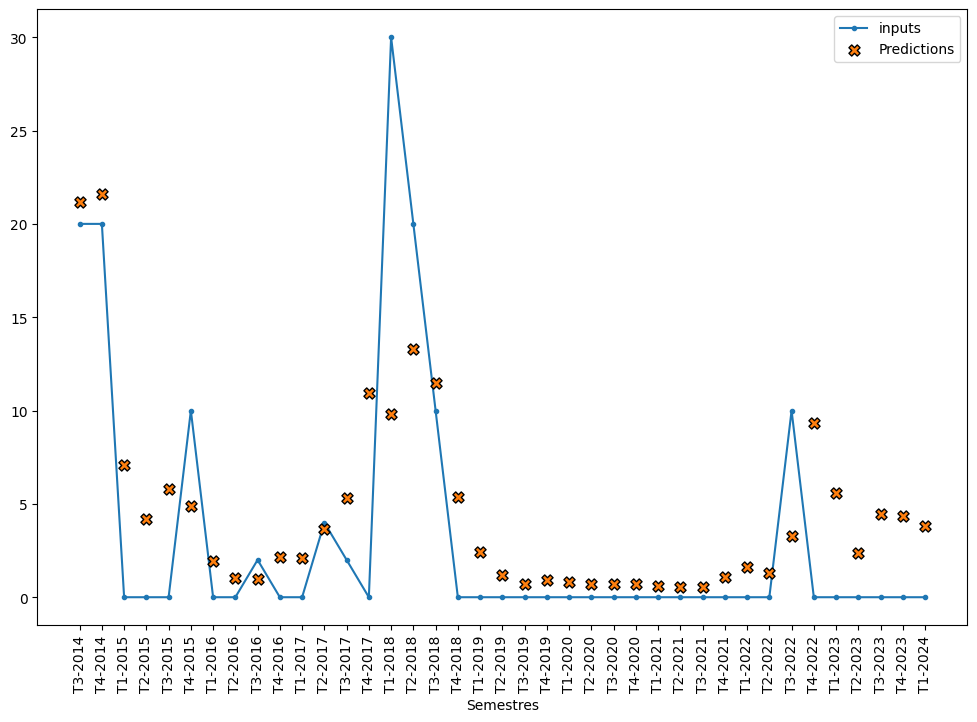

In [101]:
plt.figure(figsize=(12, 8))

plt.plot(semesters, input_semestre[-39:],
             label='inputs', marker='.', zorder=-10)

# plt.scatter(semesters[-17:], input_semestre[-17:],
#                 edgecolors='k', label='Labels', c='#2ca02c', s=64)


plt.scatter(semesters, finalpred_semestre,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

# plt.plot(semesters[-17:], finalpred_semestre,
#              label='Predictions', marker='.', zorder=-10)
plt.xticks(rotation=90)
plt.xlabel('Semestres')
plt.legend()

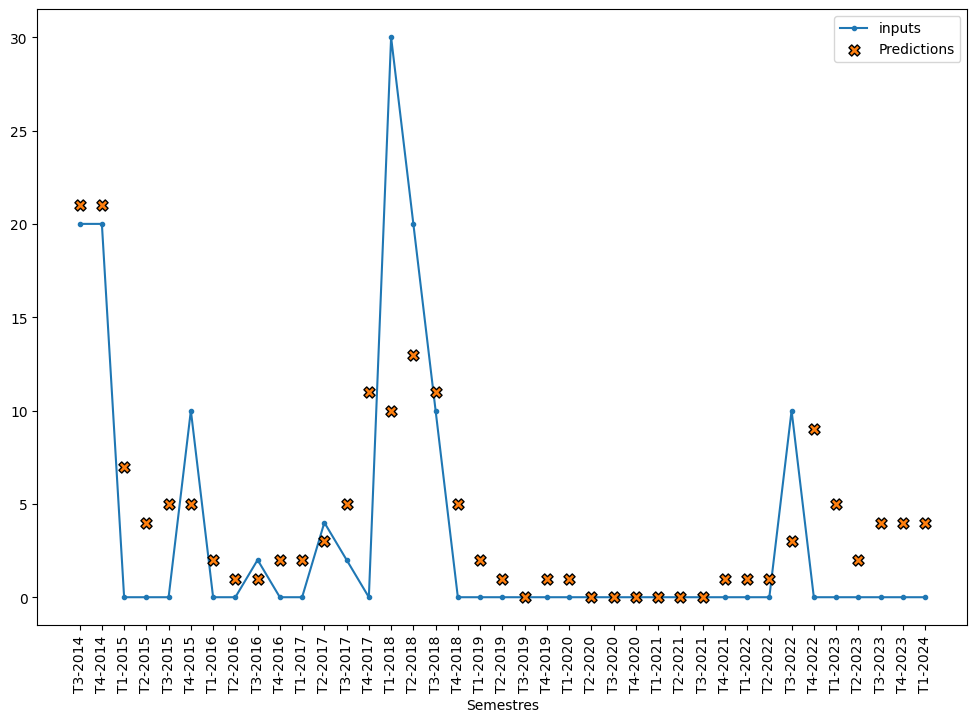

In [102]:
plt.figure(figsize=(12, 8))

plt.plot(semesters, input_semestre[-39:],
             label='inputs', marker='.', zorder=-10)

# plt.scatter(semesters[-17:], input_semestre[-17:],
#                 edgecolors='k', label='Labels', c='#2ca02c', s=64)


plt.scatter(semesters, finalpred_semestre_seuil,
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

# plt.plot(semesters[-17:], finalpred_semestre,
#              label='Predictions', marker='.', zorder=-10)
plt.xticks(rotation=90)
plt.xlabel('Semestres')
plt.legend()

In [103]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=semesters, y=input_semestre[-39:],
                                 mode='lines', name='inputs'))

fig.add_trace(go.Scatter(x=semesters, y=finalpred_semestre_seuil,
                                 mode='lines', name='Predictions'))

# Update layout
fig.update_layout(
title=f'{etude_plot} consommation par trimestre',
xaxis_title='Mois',
yaxis_title=f'{etude_print} consommation'
)

file_name = etude + "final_plot.png"
print(file_name)
# Save the plot to a file
# fig.write_image(file_name)  # You can change the file format and file path as needed
# fig.write_image(file_name, engine="orca")

# Show the plot
fig.show()


# Save figure as PNG
# fig.write_image(file_name)

CA2782376final_plot.png


In [104]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=semesters, y=input_semestre[-39:],
                                 mode='lines', name='inputs'))

fig.add_trace(go.Scatter(x=semesters[-17:], y=finalpred_semestre_seuil[-17:],
                                 mode='lines', name='Predictions'))

# Update layout
fig.update_layout(
title=f'{etude_plot} consommation par trimestre',
xaxis_title='Mois',
yaxis_title=f'{etude_print} consommation'
)

# Show the plot
fig.show()

In [105]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=semesters[-17:], y=input_semestre_cumule,
                                 mode='lines', name='inputs'))

fig.add_trace(go.Scatter(x=semesters[-17:], y=finalpred_semestre_seuil_cumule,
                                 mode='lines', name='Predictions'))





fig.update_layout(
title=f'{etude_plot} consommation par trimestre en cumulé',
xaxis_title='Mois',
yaxis_title=f'{etude_print} consommation'
)

# Show the plot
fig.show()